## Fragen

1. Analyse Allgemein
    - Lässt sich ein Zusammenhang zwischen dem Wasserpegel von den Beobachtungsdaten und den Modelldaten erkennen?
    - Wie ist die Korrelation zwischen Wasserpegel Model und Wasserpegel Beobachtung

2. Analyse Sturmfluten
    - Wie verhält sich Wind, Windrichtung bei den unterschiedlichen Sturmfluten
    - Wie vehält sich Wassergeschwindigkeit, Richtung bei den unterschiedlichen Sturmfluten
    - Lassen sich Korrelationen zwischen den Features und dem Wasserpegel (sla) erkennen? 

## Import Libaries

In [1]:
# import all necessary libraries
import os
from utils.Copernicus import AdvancedCopernicus
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import folium
from pathlib import Path

# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)


# Display all columns
pd.options.display.max_columns = None
# pd.options.display.max_rows = None

In [2]:
START_DATE = "2022-12-03"
END_DATE = "2025-03-22"
OUTPUT_FILENAME = "output.nc"

BBOX = {
    # "minimum_longitude":9.10,
    # "maximum_longitude":30.20,
    # "minimum_latitude":53.10,
    # "maximum_latitude":65.00,
    "minimum_longitude": 9.1,
    "maximum_longitude": 23.0,
    "minimum_latitude": 53.5,
    "maximum_latitude": 60.0,
    # "minimum_longitude":9.85083510071235,
    # "maximum_longitude":10.926709174713364,
    # "minimum_latitude":54.25206332481298,
    # "maximum_latitude":54.97306793985031,
    "target_min_lon": 10.156,
    "target_max_lon": 10.170,
    "target_min_lat": 54.354,
    "target_max_lat": 54.365,
}

In [3]:
ocean_points = 30
weather_points = 10

In [4]:
# Download Data
minimum_latitude = BBOX["minimum_latitude"]
maximum_latitude = BBOX["maximum_latitude"]
minimum_longitude = BBOX["minimum_longitude"]
maximum_longitude = BBOX["maximum_longitude"]

latitudes = np.linspace(minimum_latitude, maximum_latitude, weather_points)
longitudes = np.linspace(minimum_longitude, maximum_longitude, weather_points)


# zip latitudes and longitudes
coordinates = set([(float(lat), float(lon)) for lat in latitudes for lon in longitudes])
print(len(coordinates))

mean_lat = np.mean(latitudes)
mean_lon = np.mean(longitudes)
# plot the coordinates to folium

100


## Ocean Data

In [5]:
ocean_data_path = Path(f"../data/numerical_data/points{ocean_points}")
print(ocean_data_path)
weather_data_path = Path(f"../data/numerical_data/points{weather_points}")
print(weather_data_path)

../data/numerical_data/points30
../data/numerical_data/points10


In [6]:
import os
from pathlib import Path
import pandas as pd
import xarray as xr

def load_ocean_data(ocean_data_path: Path, ocean_points: str) -> pd.DataFrame:
    """
    Load and concatenate ocean data from NetCDF (.nc) files in the given directory.

    Parameters:
        ocean_data_path (Path): Path to the directory containing .nc files.
        ocean_points (str): Identifier used to exclude a specific weather data file.

    Returns:
        pd.DataFrame: Combined DataFrame of ocean data.
    """
    # Collect all .nc files
    nc_files = sorted(file for file in os.listdir(ocean_data_path) if file.endswith(".nc"))

    # Remove the weather file if it exists
    weather_file = f"df_weather{ocean_points}.nc"
    if weather_file in nc_files:
        nc_files.remove(weather_file)
        print(f"{weather_file} removed")

    # Load and combine the data
    df_list = []
    for file in nc_files:
        file_path = ocean_data_path / file
        with xr.open_dataset(file_path) as ds:
            df = ds.to_dataframe().reset_index()
            df_list.append(df)

    return pd.concat(df_list, ignore_index=True)

df_ocean = load_ocean_data(ocean_data_path, ocean_points)

In [7]:
def process_df(df: pd.DataFrame) -> pd.DataFrame:
    # df = df.dropna(axis=1, how="all")
    # df = df.dropna(axis=0, how="any")
    # drop cols with lot of missing values
    # df = df.drop(columns=['depth'], axis=1)
    df = df[["time"] + [col for col in df.columns if col != "time"]]
    float_cols = df.select_dtypes(include=["float"]).columns
    df[float_cols] = df[float_cols].astype(np.float32)
    df["time"] = pd.to_datetime(df["time"]).dt.tz_localize(None).dt.round("h")

    # df = df.groupby(by=['time', 'latitude', 'longitude']).mean().reset_index()
    df = df.reset_index(drop=True)

    return df

In [8]:

def check_missing_times(df: pd.DataFrame) -> None:
    # Zeitdifferenzen berechnen
    time_diff = df["time"].diff()

    # Falls der Zeitabstand konstant sein sollte (z. B. 1 Stunde), prüfe Abweichungen:
    expected_interval = pd.Timedelta(hours=1)  # Anpassen je nach erwartetem Intervall
    missing_times = df["time"][time_diff > expected_interval]

    # Fehlende Zeitpunkte ausgeben
    if missing_times.empty:
        print("Keine fehlenden Zeitpunkte!")
    else:
        print("Fehlende Zeitpunkte erkannt:")
        print(missing_times)

def show_df(df: pd.DataFrame) -> None:
    # show the first 5 rows of the dataframe
    display(df.head())
    # show the last 5 rows of the dataframe
    display(df.tail())

    # show columns
    print("Columns:", df.columns.tolist())

    unique_coordinates = df[["latitude", "longitude"]].drop_duplicates()
    n_unique_coordinates = len(unique_coordinates)
    print(f"Number of unique coordinates: {n_unique_coordinates}")
    print(df.info(show_counts=True, verbose=True, memory_usage="deep"))
    print(df.isna().sum())
    display(df.describe())

    check_missing_times(df)




In [9]:
df_ocean = df_ocean.dropna(axis=1, how="all")
df_ocean = df_ocean.dropna(axis=0, how="any")
df_ocean = df_ocean.drop(columns=["depth"], axis=1)
df_ocean = process_df(df_ocean)

show_df(df_ocean)

time   latitude  longitude   bottomT    mlotst  siconc  \
0 2022-12-03 00:00:00  53.724953  14.374895  3.410156  3.995598     0.0   
1 2022-12-03 01:00:00  53.724953  14.374895  3.396963  3.995263     0.0   
2 2022-12-03 02:00:00  53.724953  14.374895  3.385111  3.988039     0.0   
3 2022-12-03 03:00:00  53.724953  14.374895  3.373137  3.993156     0.0   
4 2022-12-03 04:00:00  53.724953  14.374895  3.353949  4.000775     0.0   

   sithick       sla        so       sob    thetao        uo        vo  \
0      0.0 -0.143757  0.014952  0.014953  3.406551 -0.009616  0.001145   
1      0.0 -0.144093  0.014947  0.014947  3.393593 -0.015878  0.007352   
2      0.0 -0.151317  0.014940  0.014941  3.379974 -0.014326  0.008486   
3      0.0 -0.146199  0.014927  0.014929  3.367593 -0.008735  0.001938   
4      0.0 -0.138580  0.014919  0.014920  3.349022  0.002424 -0.005228   

             wo  
0  5.893584e-08  
1  1.211367e-07  
2  1.183891e-07  
3  9.702487e-08  
4  1.172617e-07

time   latitude  longitude   bottomT     mlotst  \
9415182 2025-03-21 20:00:00  60.008183  22.986214  1.240906   9.966438   
9415183 2025-03-21 21:00:00  60.008183  22.986214  1.239942   9.963586   
9415184 2025-03-21 22:00:00  60.008183  22.986214  1.239102   9.977518   
9415185 2025-03-21 23:00:00  60.008183  22.986214  1.238123   9.996614   
9415186 2025-03-22 00:00:00  60.008183  22.986214  1.236666  10.005527   

         siconc  sithick       sla        so       sob    thetao        uo  \
9415182     0.0      0.0 -0.165247  3.858200  4.509239  1.731531 -0.021636   
9415183     0.0      0.0 -0.168364  3.857321  4.508060  1.688581 -0.018138   
9415184     0.0      0.0 -0.153143  3.858922  4.507098  1.644180 -0.012949   
9415185     0.0      0.0 -0.132281  3.861946  4.505925  1.587591 -0.010488   
9415186     0.0      0.0 -0.122543  3.865010  4.503971  1.519571 -0.014191   

               vo            wo  
9415182 -0.006870  7.547917e-09  
9415183 -0.002554  8.625824e-09  
9415184  0.004255  8.859505e-09  
9415185  0.009695  9.152139e-09  
9415186  0.010449  1.010761e-08

Columns: ['time', 'latitude', 'longitude', 'bottomT', 'mlotst', 'siconc', 'sithick', 'sla', 'so', 'sob', 'thetao', 'uo', 'vo', 'wo']
Number of unique coordinates: 467
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9415187 entries, 0 to 9415186
Data columns (total 14 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   time       9415187 non-null  datetime64[ns]
 1   latitude   9415187 non-null  float32       
 2   longitude  9415187 non-null  float32       
 3   bottomT    9415187 non-null  float32       
 4   mlotst     9415187 non-null  float32       
 5   siconc     9415187 non-null  float32       
 6   sithick    9415187 non-null  float32       
 7   sla        9415187 non-null  float32       
 8   so         9415187 non-null  float32       
 9   sob        9415187 non-null  float32       
 10  thetao     9415187 non-null  float32       
 11  uo         9415187 non-null  float32       
 12  vo         9415187 non-null  

time      latitude     longitude  \
count                        9415187  9.415187e+06  9.415187e+06   
mean   2024-01-26 23:59:59.999999488  5.685889e+01  1.676760e+01   
min              2022-12-03 00:00:00  5.372495e+01  9.097137e+00   
25%              2023-07-01 00:00:00  5.550826e+01  1.340268e+01   
50%              2024-01-27 00:00:00  5.685824e+01  1.773605e+01   
75%              2024-08-24 00:00:00  5.799155e+01  2.012502e+01   
max              2025-03-22 00:00:00  6.000818e+01  2.298621e+01   
std                              NaN  1.578268e+00  3.926184e+00   

            bottomT        mlotst        siconc       sithick           sla  \
count  9.415187e+06  9.415187e+06  9.415187e+06  9.415187e+06  9.415187e+06   
mean   7.142221e+00  1.883143e+01  4.653668e-03  1.165215e-03 -8.410597e-02   
min   -1.025859e+00  1.725482e+00  0.000000e+00  0.000000e+00 -1.665636e+00   
25%    4.826166e+00  1.008458e+01  0.000000e+00  0.000000e+00 -2.219568e-01   
50%    6.299991e+00  1.190891e+01  0.000000e+00  0.000000e+00 -7.363505e-02   
75%    7.877824e+00  2.635475e+01  0.000000e+00  0.000000e+00  4.439254e-02   
max    2.559764e+01  4.993846e+02  9.970000e-01  6.831686e-01  1.438694e+00   
std    3.847275e+00  1.339984e+01  5.997982e-02  1.397772e-02  1.977233e-01   

                 so           sob        thetao            uo            vo  \
count  9.415187e+06  9.415187e+06  9.415187e+06  9.415187e+06  9.415187e+06   
mean   1.033531e+01  1.310118e+01  9.481163e+00  5.142779e-03  7.155766e-03   
min   -7.644224e-02 -3.166307e-02 -1.552042e+00 -1.303928e+00 -1.284338e+00   
25%    6.920894e+00  7.460144e+00  4.269635e+00 -5.007034e-02 -5.180125e-02   
50%    7.301487e+00  9.722097e+00  7.717205e+00  3.423821e-03  3.016098e-03   
75%    8.100474e+00  1.257764e+01  1.543641e+01  5.991423e-02  6.100779e-02   
max    3.619087e+01  4.111121e+01  2.566385e+01  1.356585e+00  1.272928e+00   
std    7.345524e+00  9.158420e+00  5.932123e+00  1.178498e-01  1.184497e-01   

                 wo  
count  9.415187e+06  
mean  -2.093416e-07  
min   -8.305990e-04  
25%   -8.427258e-08  
50%    8.217322e-08  
75%    7.934436e-07  
max    1.299576e-04  
std    9.057704e-06

Keine fehlenden Zeitpunkte!


## Weather Data

In [10]:
# file_path = numerical_data_path / f'df_weather{weather_points}.nc'
# df_weather = xr.open_dataset(file_path).to_dataframe().reset_index()

file_path = weather_data_path / f"df_weather{weather_points}.csv"
df_weather = pd.read_csv(file_path)

print(df_weather.info(verbose=True, show_counts=True, memory_usage="deep"))
display(df_weather.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018400 entries, 0 to 2018399
Data columns (total 23 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   time                        2018400 non-null  object 
 1   latitude                    2018400 non-null  float64
 2   longitude                   2018400 non-null  float64
 3   temperature_2m              2018400 non-null  float64
 4   relative_humidity_2m        2018400 non-null  float64
 5   dew_point_2m                2018400 non-null  float64
 6   apparent_temperature        2018400 non-null  float64
 7   precipitation               2018400 non-null  float64
 8   rain                        2018400 non-null  float64
 9   showers                     2018400 non-null  float64
 10  snowfall                    2018400 non-null  float64
 11  weather_code                2018400 non-null  float64
 12  pressure_msl                2018400 non-null  float64
 1

time   latitude  longitude  temperature_2m  \
0  2022-12-03 00:00:00  54.938488  12.166998           4.337   
1  2022-12-03 01:00:00  54.938488  12.166998           4.137   
2  2022-12-03 02:00:00  54.938488  12.166998           4.287   
3  2022-12-03 03:00:00  54.938488  12.166998           4.087   
4  2022-12-03 04:00:00  54.938488  12.166998           4.137   

   relative_humidity_2m  dew_point_2m  apparent_temperature  precipitation  \
0             79.126850         1.037             -1.760069            0.0   
1             81.112920         1.187             -2.126686            0.1   
2             80.843124         1.287             -1.999586            0.1   
3             78.521065         0.687             -2.143030            0.0   
4             75.196915         0.137             -1.981791            0.0   

   rain  showers  snowfall  weather_code  pressure_msl  surface_pressure  \
0   0.0      0.0       0.0           3.0        1029.4         1027.8805   
1   0.1      0.0       0.0          51.0        1029.2         1027.6797   
2   0.1      0.0       0.0          51.0        1029.0         1027.4807   
3   0.0      0.0       0.0           3.0        1028.7         1027.1800   
4   0.0      0.0       0.0           3.0        1028.4         1026.8810   

   cloud_cover  cloud_cover_low  cloud_cover_mid  cloud_cover_high  \
0        100.0            100.0            100.0              89.0   
1        100.0            100.0            100.0              27.0   
2        100.0            100.0             99.0              42.0   
3        100.0            100.0            100.0              99.0   
4        100.0            100.0            100.0             100.0   

   et0_fao_evapotranspiration  vapour_pressure_deficit  wind_speed_10m  \
0                    0.027642                 0.174289       28.373846   
1                    0.024795                 0.155512       29.686360   
2                    0.025658                 0.159400       29.957968   
3                    0.028692                 0.176232       28.894344   
4                    0.033386                 0.204220       27.534704   

   wind_direction_10m  wind_gusts_10m  
0           54.293217       53.280000  
1           50.906155       48.960000  
2           57.264786       50.399998  
3           59.281166       49.680000  
4           64.440094       48.239998

In [11]:
df_weather = process_df(df_weather)
# df_weather = df_weather.dropna(axis=1, how="all")
# df_weather = df_weather.dropna(axis=0, how="any")

show_df(df_weather)


time   latitude  longitude  temperature_2m  \
0 2022-12-03 00:00:00  54.938488  12.166998           4.337   
1 2022-12-03 01:00:00  54.938488  12.166998           4.137   
2 2022-12-03 02:00:00  54.938488  12.166998           4.287   
3 2022-12-03 03:00:00  54.938488  12.166998           4.087   
4 2022-12-03 04:00:00  54.938488  12.166998           4.137   

   relative_humidity_2m  dew_point_2m  apparent_temperature  precipitation  \
0             79.126846         1.037             -1.760069            0.0   
1             81.112923         1.187             -2.126686            0.1   
2             80.843124         1.287             -1.999586            0.1   
3             78.521065         0.687             -2.143030            0.0   
4             75.196915         0.137             -1.981791            0.0   

   rain  showers  snowfall  weather_code  pressure_msl  surface_pressure  \
0   0.0      0.0       0.0           3.0   1029.400024       1027.880493   
1   0.1      0.0       0.0          51.0   1029.199951       1027.679688   
2   0.1      0.0       0.0          51.0   1029.000000       1027.480713   
3   0.0      0.0       0.0           3.0   1028.699951       1027.180054   
4   0.0      0.0       0.0           3.0   1028.400024       1026.880981   

   cloud_cover  cloud_cover_low  cloud_cover_mid  cloud_cover_high  \
0        100.0            100.0            100.0              89.0   
1        100.0            100.0            100.0              27.0   
2        100.0            100.0             99.0              42.0   
3        100.0            100.0            100.0              99.0   
4        100.0            100.0            100.0             100.0   

   et0_fao_evapotranspiration  vapour_pressure_deficit  wind_speed_10m  \
0                    0.027642                 0.174289       28.373846   
1                    0.024795                 0.155512       29.686359   
2                    0.025658                 0.159400       29.957968   
3                    0.028692                 0.176232       28.894344   
4                    0.033386                 0.204220       27.534704   

   wind_direction_10m  wind_gusts_10m  
0           54.293217       53.279999  
1           50.906155       48.959999  
2           57.264786       50.399998  
3           59.281166       49.680000  
4           64.440094       48.239998

time   latitude  longitude  temperature_2m  \
2018395 2025-03-22 19:00:00  57.820736  16.753246            3.85   
2018396 2025-03-22 20:00:00  57.820736  16.753246            3.85   
2018397 2025-03-22 21:00:00  57.820736  16.753246            4.05   
2018398 2025-03-22 22:00:00  57.820736  16.753246            4.35   
2018399 2025-03-22 23:00:00  57.820736  16.753246            4.50   

         relative_humidity_2m  dew_point_2m  apparent_temperature  \
2018395             84.339890          1.45             -1.453786   
2018396             83.138748          1.25             -1.600677   
2018397             82.866226          1.40             -1.396805   
2018398             80.851936          1.35             -1.190087   
2018399             79.151413          1.20             -1.024518   

         precipitation  rain  showers  snowfall  weather_code  pressure_msl  \
2018395            0.0   0.0      0.0       0.0           0.0   1028.300049   
2018396            0.0   0.0      0.0       0.0           0.0   1028.000000   
2018397            0.0   0.0      0.0       0.0           0.0   1027.800049   
2018398            0.0   0.0      0.0       0.0           0.0   1027.400024   
2018399            0.0   0.0      0.0       0.0           0.0   1027.000000   

         surface_pressure  cloud_cover  cloud_cover_low  cloud_cover_mid  \
2018395       1028.300049          0.0              0.0              0.0   
2018396       1028.000000          0.0              0.0              0.0   
2018397       1027.800049          0.0              0.0              0.0   
2018398       1027.400024          0.0              0.0              0.0   
2018399       1027.000000          0.0              0.0              0.0   

         cloud_cover_high  et0_fao_evapotranspiration  \
2018395               0.0                    0.014923   
2018396               0.0                    0.017347   
2018397               0.0                    0.018082   
2018398               0.0                    0.022108   
2018399               0.0                    0.024853   

         vapour_pressure_deficit  wind_speed_10m  wind_direction_10m  \
2018395                 0.126370       23.406229           91.321953   
2018396                 0.136063       24.183052           98.130020   
2018397                 0.140218       24.329315          105.887238   
2018398                 0.160031       24.911634          113.416046   
2018399                 0.176081       24.633049          116.939445   

         wind_gusts_10m  
2018395       30.239998  
2018396       30.599998  
2018397       30.599998  
2018398       31.680000  
2018399       31.319998

Columns: ['time', 'latitude', 'longitude', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature', 'precipitation', 'rain', 'showers', 'snowfall', 'weather_code', 'pressure_msl', 'surface_pressure', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 'et0_fao_evapotranspiration', 'vapour_pressure_deficit', 'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m']
Number of unique coordinates: 100
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018400 entries, 0 to 2018399
Data columns (total 23 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   time                        2018400 non-null  datetime64[ns]
 1   latitude                    2018400 non-null  float32       
 2   longitude                   2018400 non-null  float32       
 3   temperature_2m              2018400 non-null  float32       
 4   relative_humidity_2m        2018400 non

time      latitude     longitude  \
count                        2018400  2.018400e+06  2.018400e+06   
mean   2024-01-27 11:30:00.000001536  5.675219e+01  1.606228e+01   
min              2022-12-03 00:00:00  5.353251e+01  8.979118e+00   
25%              2023-07-01 05:45:00  5.493849e+01  1.222792e+01   
50%              2024-01-27 11:30:00  5.676625e+01  1.603017e+01   
75%              2024-08-24 17:15:00  5.852372e+01  1.990181e+01   
max              2025-03-22 23:00:00  6.000000e+01  2.309734e+01   
std                              NaN  2.068218e+00  4.440003e+00   

       temperature_2m  relative_humidity_2m  dew_point_2m  \
count    2.018400e+06          2.018400e+06  2.018400e+06   
mean     7.863672e+00          8.084811e+01  4.484694e+00   
min     -3.330350e+01          1.229409e+01 -3.580350e+01   
25%      2.221500e+00          7.347512e+01 -3.000000e-01   
50%      6.650000e+00          8.392735e+01  3.950000e+00   
75%      1.440000e+01          9.128604e+01  1.026500e+01   
max      3.393050e+01          1.000000e+02  2.416500e+01   
std      7.641475e+00          1.401187e+01  6.973755e+00   

       apparent_temperature  precipitation          rain    showers  \
count          2.018400e+06   2.018400e+06  2.018400e+06  2018400.0   
mean           4.265367e+00   9.403422e-02  7.855469e-02        0.0   
min           -3.844448e+01   0.000000e+00  0.000000e+00        0.0   
25%           -2.860585e+00   0.000000e+00  0.000000e+00        0.0   
50%            2.410487e+00   0.000000e+00  0.000000e+00        0.0   
75%            1.222969e+01   0.000000e+00  0.000000e+00        0.0   
max            3.468115e+01   2.610000e+01  2.610000e+01        0.0   
std            9.233553e+00   3.782145e-01  3.577255e-01        0.0   

           snowfall  weather_code  pressure_msl  surface_pressure  \
count  2.018400e+06  2.018400e+06  2.018400e+06      2.018400e+06   
mean   1.086054e-02  1.253946e+01  1.013017e+03      1.005390e+03   
min    0.000000e+00  0.000000e+00  9.579000e+02      8.762991e+02   
25%    0.000000e+00  1.000000e+00  1.005500e+03      9.967036e+02   
50%    0.000000e+00  3.000000e+00  1.013700e+03      1.007700e+03   
75%    0.000000e+00  3.000000e+00  1.021200e+03      1.016868e+03   
max    4.200000e+00  7.500000e+01  1.052000e+03      1.052000e+03   
std    8.137128e-02  2.205626e+01  1.179669e+01      1.742536e+01   

        cloud_cover  cloud_cover_low  cloud_cover_mid  cloud_cover_high  \
count  2.018400e+06     2.018400e+06     2.018400e+06      2.018400e+06   
mean   6.872610e+01     4.074061e+01     3.335294e+01      4.266039e+01   
min    0.000000e+00     0.000000e+00     0.000000e+00      0.000000e+00   
25%    2.700000e+01     0.000000e+00     0.000000e+00      0.000000e+00   
50%    9.900000e+01     1.700000e+01     7.000000e+00      1.800000e+01   
75%    1.000000e+02     1.000000e+02     8.100000e+01      9.900000e+01   
max    1.000000e+02     1.000000e+02     1.000000e+02      1.000000e+02   
std    4.011200e+01     4.367327e+01     4.111896e+01      4.487413e+01   

       et0_fao_evapotranspiration  vapour_pressure_deficit  wind_speed_10m  \
count                2.018400e+06             2.018400e+06    2.018400e+06   
mean                 6.939780e-02             2.635497e-01    1.797662e+01   
min                  0.000000e+00             0.000000e+00    0.000000e+00   
25%                  4.823437e-03             7.097840e-02    9.965239e+00   
50%                  2.707617e-02             1.545327e-01    1.553015e+01   
75%                  8.146853e-02             3.245316e-01    2.362393e+01   
max                  7.007209e-01             3.658855e+00    8.853987e+01   
std                  1.017334e-01             3.185597e-01    1.083381e+01   

       wind_direction_10m  wind_gusts_10m  
count        2.018400e+06    2.018400e+06  
mean         1.938843e+02    3.048960e+01  
min          1.824665e-01    3.600000e-01  
25%          1.216075e+02    1.908000e+01  
50%     

Keine fehlenden Zeitpunkte!


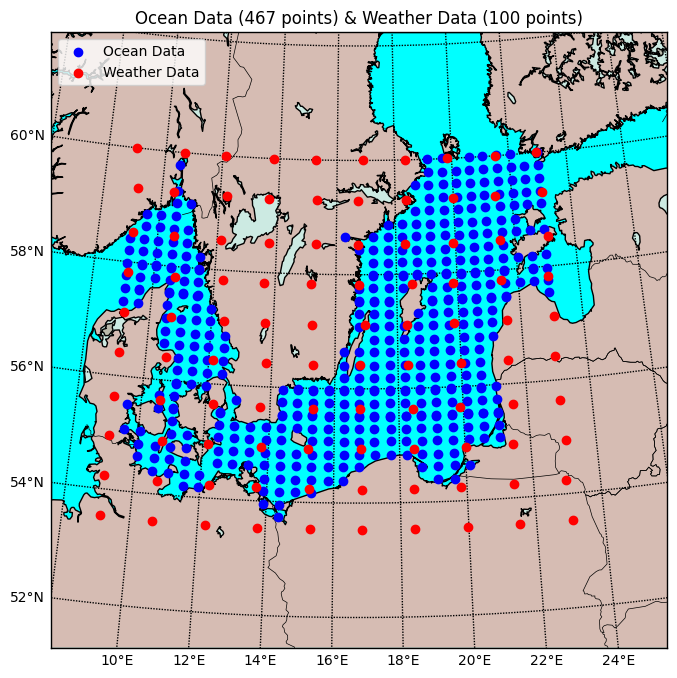

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import numpy as np

def plot_coordinates(df_ocean: pd.DataFrame, df_weather: pd.DataFrame, save_png: bool = False) -> None:
    """
    Plot ocean and weather coordinates on a map using Basemap.

    Parameters:
        df_ocean (pd.DataFrame): DataFrame containing ocean data with 'latitude' and 'longitude'.
        df_weather (pd.DataFrame): DataFrame containing weather data with 'latitude' and 'longitude'.
        save_png (bool): Whether to save the map as a PNG file. Default is False.
    """
    # Drop duplicate coordinates
    ocean_coords = df_ocean[["latitude", "longitude"]].drop_duplicates()
    weather_coords = df_weather[["latitude", "longitude"]].drop_duplicates()

    # Count for filename and label
    num_ocean_coords = len(ocean_coords)
    num_weather_coords = len(weather_coords)

    # Calculate mean coordinates for map centering
    mean_lat = ocean_coords["latitude"].mean()
    mean_lon = ocean_coords["longitude"].mean()

    # Create map
    plt.figure(figsize=(10, 8))
    m = Basemap(
        projection="lcc",
        resolution="i",
        lat_0=mean_lat,
        lon_0=mean_lon,
        width=1.2e6,
        height=1.2e6,
    )

    # Draw map features
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color="0.8")
    m.drawstates()
    m.drawmapboundary(fill_color="aqua")
    m.fillcontinents(color="coral", lake_color="aqua", alpha=0.2)

    # Convert lat/lon to map projection coordinates
    x_ocean, y_ocean = m(ocean_coords["longitude"].values, ocean_coords["latitude"].values)
    x_weather, y_weather = m(weather_coords["longitude"].values, weather_coords["latitude"].values)

    # Plot points
    m.scatter(x_ocean, y_ocean, color="blue", label="Ocean Data", zorder=5)
    m.scatter(x_weather, y_weather, color="red", label="Weather Data", zorder=5)

    # Add labels and grid
    plt.title(f"Ocean Data ({num_ocean_coords} points) & Weather Data ({num_weather_coords} points)")
    plt.legend(loc="upper left")
    m.drawparallels(np.arange(-90, 91, 2), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180, 181, 2), labels=[0, 0, 0, 1])

    # Save plot if requested
    if save_png:
        filename = f"map_oceanpoints_{num_ocean_coords}_weatherpoints_{num_weather_coords}.png"
        plt.savefig(filename, dpi=300)
        print(f"Map saved as {filename}")

    plt.show()

plot_coordinates(df_ocean, df_weather, save_png=False)

In [13]:
timepoint = "2023-10-20T12:00:00"

100%|██████████| 2500/2500 [00:17<00:00, 139.99it/s]


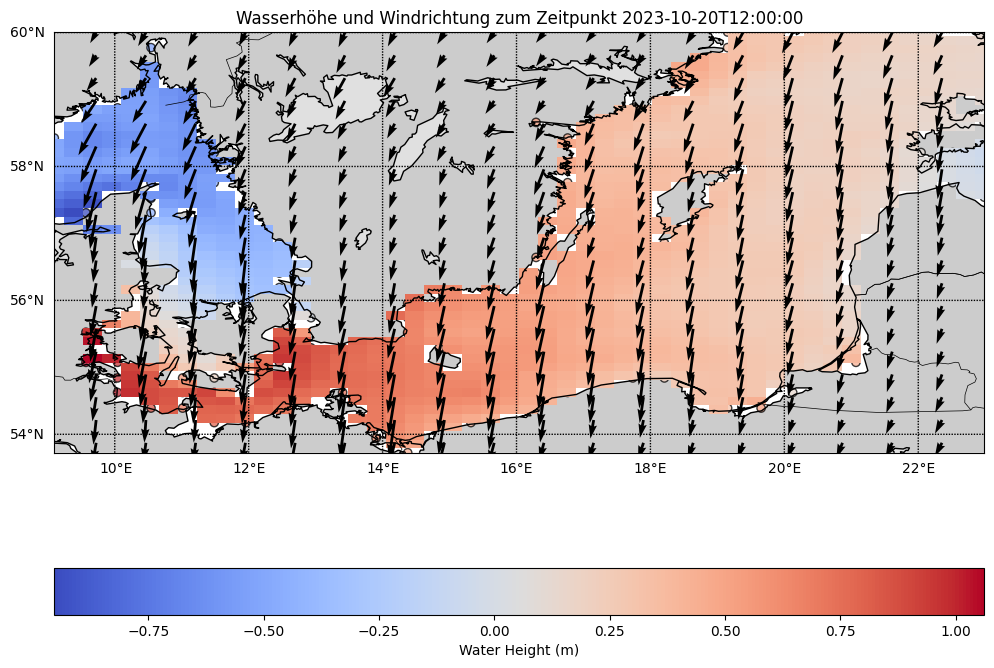

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata
import cartopy.feature as cfeature
import shapely.geometry
from joblib import Parallel, delayed
from tqdm import tqdm


# Funktion zur Landprüfung mit Cartopy
def is_on_land(lon, lat):
    land = cfeature.NaturalEarthFeature("physical", "land", "10m")
    for geom in land.geometries():
        if geom.contains(shapely.geometry.Point(lon, lat)):
            return True
    return False


# Funktion zum Erstellen der Landmaske
def create_land_mask(lon_grid, lat_grid):
    coords_list = [(lon, lat) for lat in lat_grid for lon in lon_grid]
    mask_flat = Parallel(n_jobs=-1)(
        delayed(lambda p: not is_on_land(*p))(p) for p in tqdm(coords_list)
    )
    return np.array(mask_flat).reshape(len(lat_grid), len(lon_grid))


# Daten filtern
df_weather_time = df_weather[df_weather["time"] == timepoint]
df_ocean_time = df_ocean[df_ocean["time"] == timepoint]

# Gitter für Ozeandaten
grid_size = 50
lon_grid = np.linspace(
    df_ocean_time["longitude"].min(), df_ocean_time["longitude"].max(), grid_size
)
lat_grid = np.linspace(
    df_ocean_time["latitude"].min(), df_ocean_time["latitude"].max(), grid_size
)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

# Interpolation der SLA-Werte
sla_grid = griddata(
    (df_ocean_time["longitude"], df_ocean_time["latitude"]),
    df_ocean_time["sla"],
    (lon_mesh, lat_mesh),
    method="linear",
)

# Basemap erstellen
fig, ax = plt.subplots(figsize=(12, 10))
m = Basemap(
    projection="cyl",
    resolution="i",
    llcrnrlon=lon_grid.min(),
    urcrnrlon=lon_grid.max(),
    llcrnrlat=lat_grid.min(),
    urcrnrlat=lat_grid.max(),
    ax=ax,
)
m.fillcontinents(color="grey", lake_color="white", alpha=0.4)

m.drawcoastlines()
m.drawcountries()

# Landmaske berechnen und anwenden
mask = create_land_mask(lon_grid, lat_grid)
sla_grid[~mask] = np.nan

# Scatterplot für Ozeandaten
x, y = m(df_ocean_time["longitude"].values, df_ocean_time["latitude"].values)
m.scatter(x, y, c=df_ocean_time["sla"], cmap="coolwarm", edgecolor="k", alpha=0.75)

# Heatmap für interpolierte SLA-Werte
x_mesh, y_mesh = m(lon_mesh, lat_mesh)
heatmap = m.pcolormesh(x_mesh, y_mesh, sla_grid, cmap="coolwarm", shading="auto")
plt.colorbar(heatmap, ax=ax, orientation="horizontal", label="Water Height (m)")

# Gitter für Winddaten
wind_grid_size = 20
lon_grid_wind = np.linspace(
    df_weather_time["longitude"].min(),
    df_weather_time["longitude"].max(),
    wind_grid_size,
)
lat_grid_wind = np.linspace(
    df_weather_time["latitude"].min(), df_weather_time["latitude"].max(), wind_grid_size
)
lon_mesh_wind, lat_mesh_wind = np.meshgrid(lon_grid_wind, lat_grid_wind)

# Interpolation der Windgeschwindigkeit und -richtung
wind_speed_grid = griddata(
    (df_weather_time["longitude"], df_weather_time["latitude"]),
    df_weather_time["wind_speed_10m"],
    (lon_mesh_wind, lat_mesh_wind),
    method="linear",
)
wind_dir_grid = griddata(
    (df_weather_time["longitude"], df_weather_time["latitude"]),
    df_weather_time["wind_direction_10m"],
    (lon_mesh_wind, lat_mesh_wind),
    method="linear",
)

# Windvektoren berechnen und plotten
u = wind_speed_grid * -np.cos(np.deg2rad(wind_dir_grid))
v = wind_speed_grid * -np.sin(np.deg2rad(wind_dir_grid))
x_wind, y_wind = m(lon_mesh_wind, lat_mesh_wind)
m.quiver(x_wind, y_wind, u, v, scale=1500, color="black")

m.drawparallels(np.arange(0, 360, 2), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(0, 350, 2), labels=[0, 0, 0, 1])


plt.title(f"Wasserhöhe und Windrichtung zum Zeitpunkt {timepoint}")
plt.show()


## Test mit xarray on weather data

In [15]:
def interpolate_xarray(ds, resolution=0.25, make_fine_grid=True, interpolate_nan=True):
    """
    Interpolates the xarray dataset to a finer grid.

    Parameters:
        ds (xarray.Dataset): The input dataset to interpolate.
        resolution (float): The desired resolution for the interpolation.

    Returns:
        xarray.Dataset: The interpolated dataset.
    """

    if interpolate_nan:
        # Interpolation von NaN-Werten
        ds = ds.interpolate_na(dim="time", method="linear")
        ds = ds.interpolate_na(dim="latitude", method="linear")
        ds = ds.interpolate_na(dim="longitude", method="linear")
    
    if make_fine_grid:
        # Neues feineres Gitter erzeugen
        new_lats = np.arange(ds.latitude.min(), ds.latitude.max(), resolution)
        new_lons = np.arange(ds.longitude.min(), ds.longitude.max(), resolution)

        # Interpolation
        ds = ds.interp(latitude=new_lats, longitude=new_lons, method="linear")
  
    return ds

In [ ]:
resolution = 0.25 # 0.25 degrees

In [17]:
ds_ocean = df_ocean.set_index(["time", "latitude", "longitude"]).to_xarray()
ds_ocean_interp = interpolate_xarray(ds_ocean, resolution=resolution, make_fine_grid=True, interpolate_nan=True)

In [18]:
ds_ocean_interp

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 20161, latitude: 26, longitude: 56)
Coordinates:
  * time       (time) datetime64[ns] 161kB 2022-12-03 ... 2025-03-22
  * latitude   (latitude) float64 208B 53.72 53.97 54.22 ... 59.47 59.72 59.97
  * longitude  (longitude) float64 448B 9.097 9.347 9.597 ... 22.35 22.6 22.85
Data variables:
    bottomT    (time, latitude, longitude) float64 235MB nan nan ... 1.492 1.427
    mlotst     (time, latitude, longitude) float64 235MB nan nan ... 10.94 10.93
    siconc     (time, latitude, longitude) float64 235MB nan nan nan ... 0.0 0.0
    sithick    (time, latitude, longitude) float64 235MB nan nan nan ... 0.0 0.0
    sla        (time, latitude, longitude) float64 235MB nan nan ... -0.1264
    so         (time, latitude, longitude) float64 235MB nan nan ... 4.983 4.489
    sob        (time, latitude, longitude) float64 235MB nan nan ... 5.343 4.975
    thetao     (time, latitude, longitude) float64 235MB nan nan ... 1.728 1.665
    uo         (time, latitude, longitude) float64 235MB nan nan ... -0.02442
    vo         (time, latitude, longitude) float64 235MB nan nan ... 0.01257
    wo         (time, latitude, longitude) float64 235MB nan nan ... -1.097e-07

In [19]:
ds_weather = df_weather.set_index(["time", "latitude", "longitude"]).to_xarray()

ds_weather_interp = interpolate_xarray(ds_weather, resolution=resolution, make_fine_grid=True, interpolate_nan=True)
ds_weather_interp

<xarray.Dataset> Size: 5GB
Dimensions:                     (time: 20184, latitude: 26, longitude: 57)
Coordinates:
  * time                        (time) datetime64[ns] 161kB 2022-12-03 ... 20...
  * latitude                    (latitude) float64 208B 53.53 53.78 ... 59.78
  * longitude                   (longitude) float64 456B 8.979 9.229 ... 22.98
Data variables: (12/20)
    temperature_2m              (time, latitude, longitude) float64 239MB nan...
    relative_humidity_2m        (time, latitude, longitude) float64 239MB nan...
    dew_point_2m                (time, latitude, longitude) float64 239MB nan...
    apparent_temperature        (time, latitude, longitude) float64 239MB nan...
    precipitation               (time, latitude, longitude) float64 239MB nan...
    rain                        (time, latitude, longitude) float64 239MB nan...
    ...                          ...
    cloud_cover_high            (time, latitude, longitude) float64 239MB nan...
    et0_fao_evapotranspiration  (time, latitude, longitude) float64 239MB nan...
    vapour_pressure_deficit     (time, latitude, longitude) float64 239MB nan...
    wind_speed_10m              (time, latitude, longitude) float64 239MB nan...
    wind_direction_10m          (time, latitude, longitude) float64 239MB nan...
    wind_gusts_10m              (time, latitude, longitude) float64 239MB nan...

In [20]:
# Gemeinsame Zeitachse bestimmen
common_time = np.intersect1d(ds_ocean_interp.time.values, ds_weather_interp.time.values)

# Zeitachsen angleichen
ds_ocean_interp = ds_ocean_interp.sel(time=common_time)
ds_weather_interp = ds_weather_interp.sel(time=common_time)


In [21]:
# Wetterdaten auf Ozean-Gitter bringen
ds_weather_interp = ds_weather_interp.interp(
    latitude=ds_ocean_interp.latitude,
    longitude=ds_ocean_interp.longitude
)

ds_weather_interp = interpolate_xarray(ds_weather_interp, resolution=resolution, make_fine_grid=False, interpolate_nan=True)
ds_ocean_interp = interpolate_xarray(ds_ocean_interp, resolution=resolution, make_fine_grid=False, interpolate_nan=True)

In [22]:
import geopandas as gpd
import geodatasets
import shapely.geometry
import xarray as xr
import numpy as np

def create_ocean_mask(ds, land):
    import shapely.geometry
    import geopandas as gpd
    import numpy as np
    import xarray as xr

    lon, lat = np.meshgrid(ds.longitude.values, ds.latitude.values)
    points = [shapely.geometry.Point(x, y) for x, y in zip(lon.flatten(), lat.flatten())]

    points_gdf = gpd.GeoDataFrame(geometry=points, crs=land.crs)
    joined = gpd.sjoin(points_gdf, land, predicate="within", how="left")
    on_land = ~joined.index_right.isna()

    mask_land = np.array(on_land).reshape(lat.shape)
    mask_ocean = ~mask_land

    ocean_mask_xr = xr.DataArray(
        mask_ocean,
        coords={"latitude": ds.latitude, "longitude": ds.longitude},
        dims=["latitude", "longitude"]
    )
    return ocean_mask_xr


In [23]:
land = gpd.read_file(geodatasets.get_path("naturalearth.land"))
ocean_mask = create_ocean_mask(ds_weather_interp, land)
ds_weather_ocean_only = ds_weather_interp.where(ocean_mask)
ds_ocean_ocean_only = ds_ocean_interp.where(ocean_mask)

In [24]:
ds_ocean_ocean_only

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 20161, latitude: 26, longitude: 56)
Coordinates:
  * time       (time) datetime64[ns] 161kB 2022-12-03 ... 2025-03-22
  * latitude   (latitude) float64 208B 53.72 53.97 54.22 ... 59.47 59.72 59.97
  * longitude  (longitude) float64 448B 9.097 9.347 9.597 ... 22.35 22.6 22.85
Data variables:
    bottomT    (time, latitude, longitude) float64 235MB nan nan ... 1.492 nan
    mlotst     (time, latitude, longitude) float64 235MB nan nan ... 10.94 nan
    siconc     (time, latitude, longitude) float64 235MB nan nan nan ... 0.0 nan
    sithick    (time, latitude, longitude) float64 235MB nan nan nan ... 0.0 nan
    sla        (time, latitude, longitude) float64 235MB nan nan ... -0.1314 nan
    so         (time, latitude, longitude) float64 235MB nan nan ... 4.983 nan
    sob        (time, latitude, longitude) float64 235MB nan nan ... 5.343 nan
    thetao     (time, latitude, longitude) float64 235MB nan nan ... 1.728 nan
    uo         (time, latitude, longitude) float64 235MB nan nan ... nan
    vo         (time, latitude, longitude) float64 235MB nan nan ... 0.01683 nan
    wo         (time, latitude, longitude) float64 235MB nan nan ... nan

In [25]:
ds_merged = xr.merge([ds_ocean_ocean_only, ds_weather_ocean_only])


In [26]:
ds_merged

<xarray.Dataset> Size: 7GB
Dimensions:                     (time: 20161, latitude: 26, longitude: 56)
Coordinates:
  * time                        (time) datetime64[ns] 161kB 2022-12-03 ... 20...
  * latitude                    (latitude) float64 208B 53.72 53.97 ... 59.97
  * longitude                   (longitude) float64 448B 9.097 9.347 ... 22.85
Data variables: (12/31)
    bottomT                     (time, latitude, longitude) float64 235MB nan...
    mlotst                      (time, latitude, longitude) float64 235MB nan...
    siconc                      (time, latitude, longitude) float64 235MB nan...
    sithick                     (time, latitude, longitude) float64 235MB nan...
    sla                         (time, latitude, longitude) float64 235MB nan...
    so                          (time, latitude, longitude) float64 235MB nan...
    ...                          ...
    cloud_cover_high            (time, latitude, longitude) float64 235MB nan...
    et0_fao_evapotranspiration  (time, latitude, longitude) float64 235MB nan...
    vapour_pressure_deficit     (time, latitude, longitude) float64 235MB nan...
    wind_speed_10m              (time, latitude, longitude) float64 235MB nan...
    wind_direction_10m          (time, latitude, longitude) float64 235MB nan...
    wind_gusts_10m              (time, latitude, longitude) float64 235MB nan...

Ziel: Berechnet die Pearson-Korrelation zwischen zwei Xarray-Daten (x und y), wobei dim='time' spezifiziert, dass die Korrelation entlang der Zeitdimension durchgeführt wird.

xr.corr: Dies ist eine Funktion von Xarray, die den Pearson-Korrelationskoeffizienten zwischen zwei Variablen berechnet, indem sie ihre Werte entlang einer bestimmten Dimension (in diesem Fall time) vergleicht.

x und y sind die beiden Xarray-Datenarrays (z. B. Zeitserien von sla und pressure_msl).
dim='time' bedeutet, dass die Korrelation für jede räumliche Position über die Zeit hinweg berechnet wird. Zum Beispiel, wenn du Zeitserien für verschiedene geografische Punkte hast, wird der Korrelationswert für jeden Punkt berechnet.

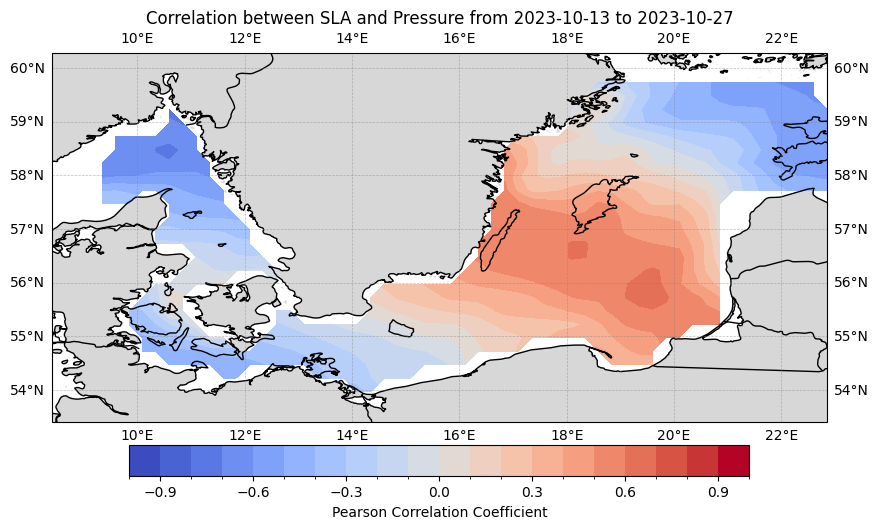

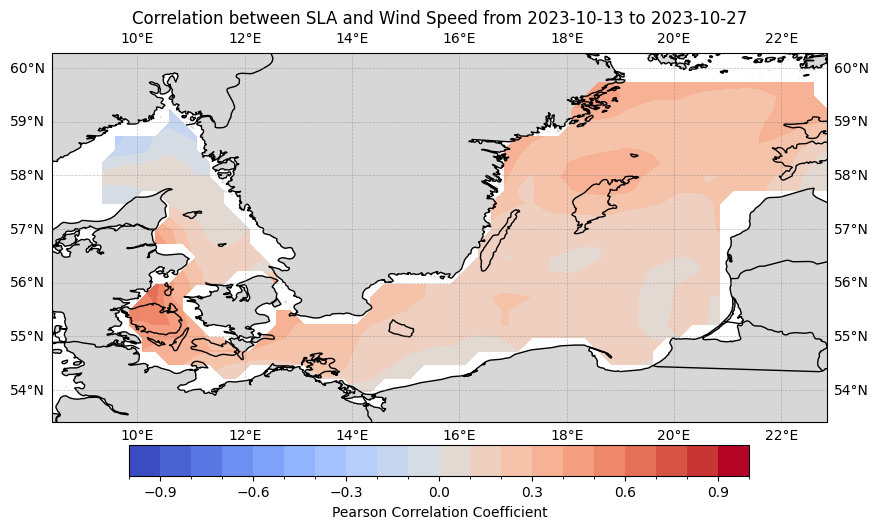

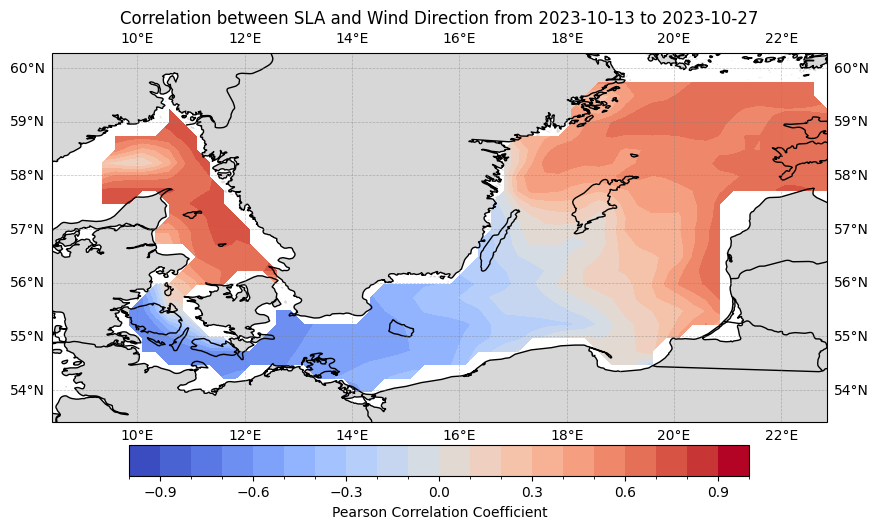

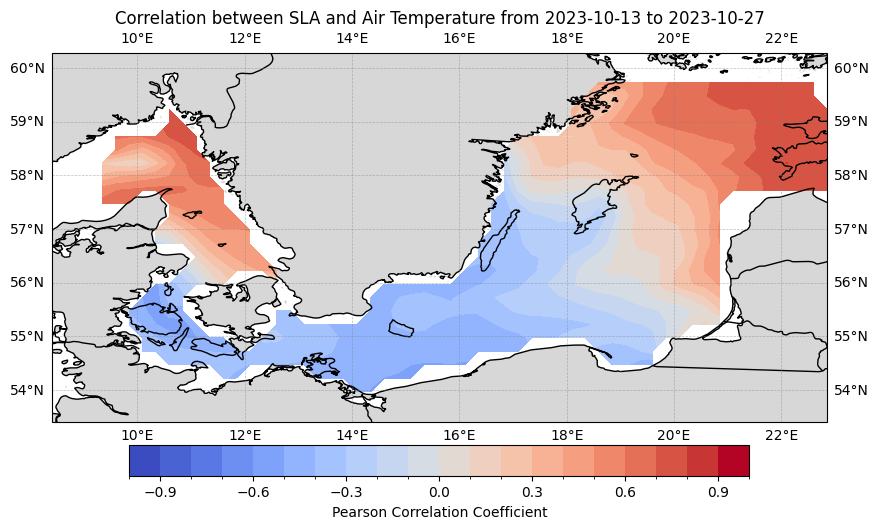

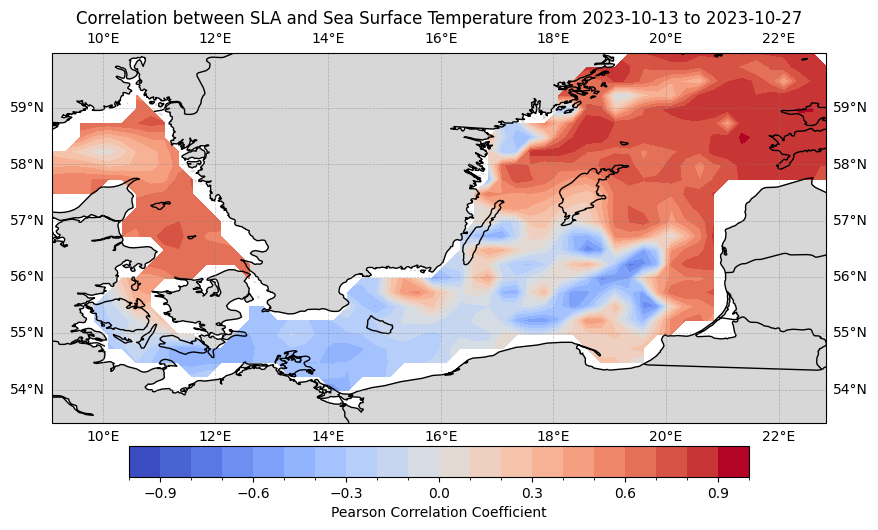

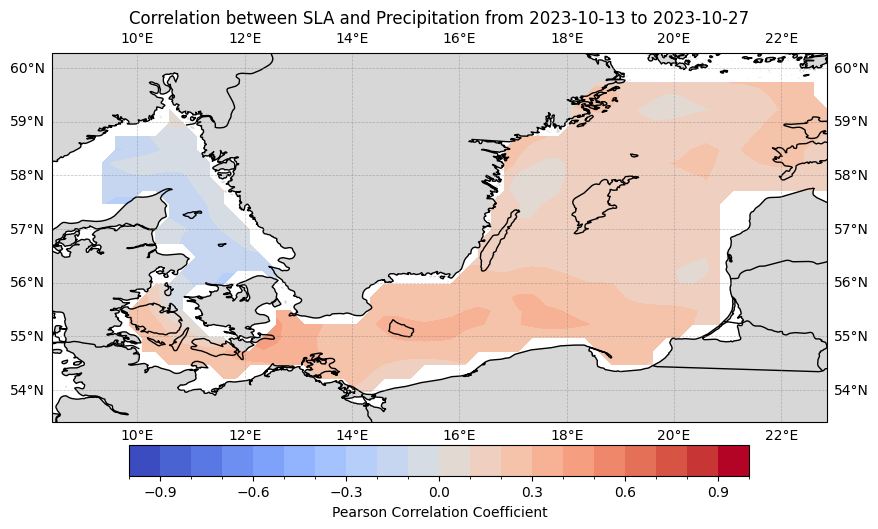

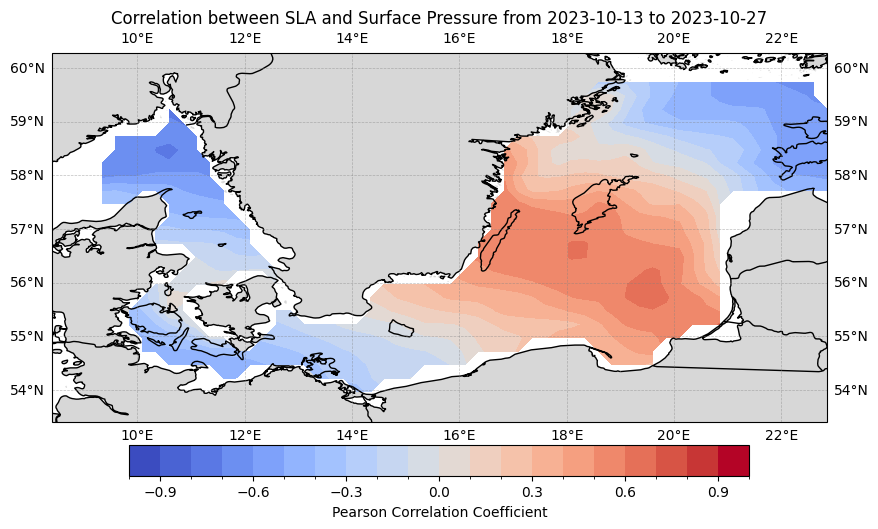

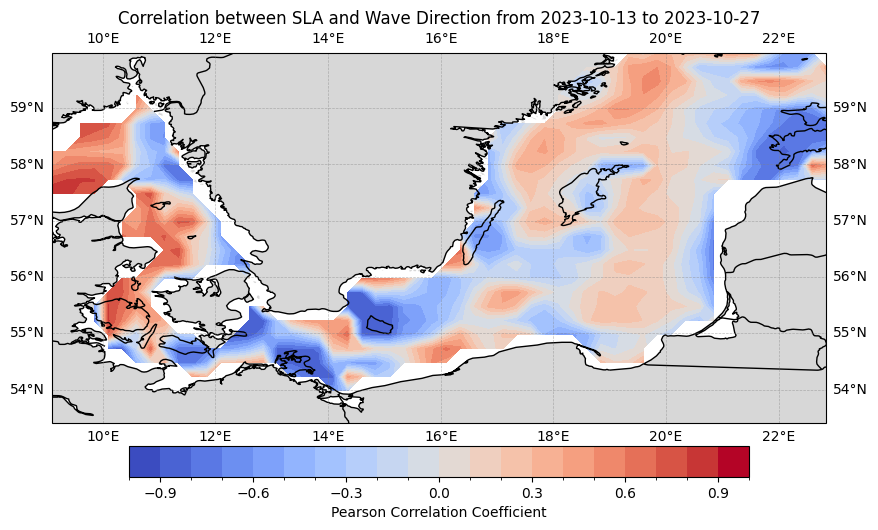

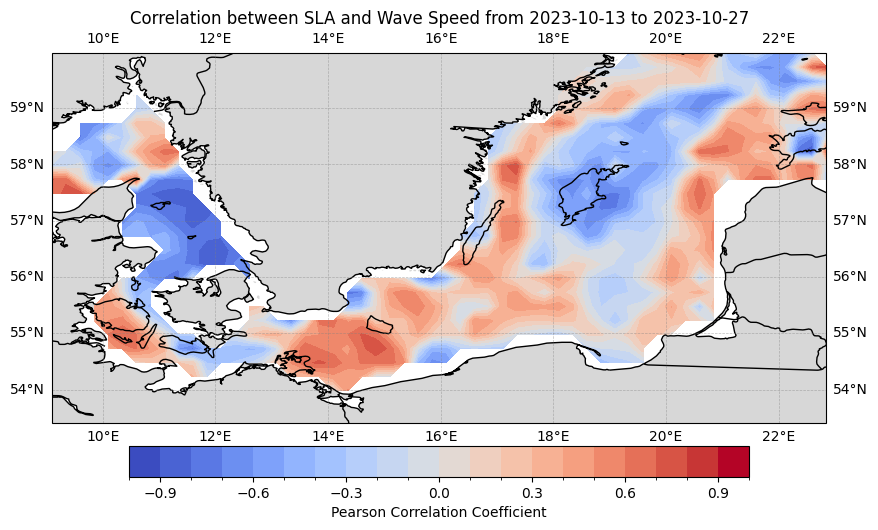

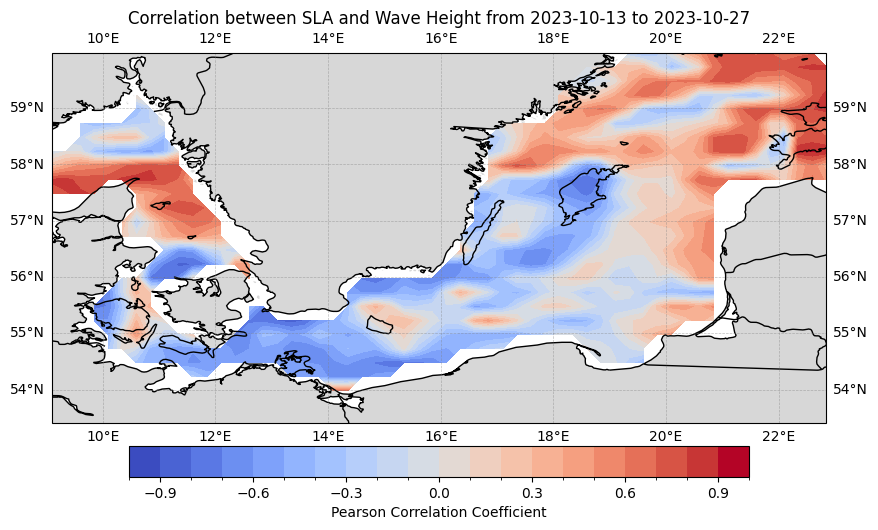

In [58]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Select subset of data from start_time to end_time
start_time = "2023-10-13"
end_time = "2023-10-27"


# start_time = ds_merged.time.min().values
# end_time = ds_merged.time.max().values

time_string = f"{start_time} to {end_time}"

ds_merged_sub = ds_merged.sel(time=slice(start_time, end_time))

def pearson_r(x, y):
    return xr.corr(x, y, dim='time')

def plot_correlation(x, y, title="Correlation Map (Contour)"):
    """
    Plots the correlation map as a contour plot using Cartopy.
    
    Parameters:
        x, y (xarray.DataArray): Variables to compute correlation from.
        title (str): Title of the plot.
    """
    correlation_map = pearson_r(x, y)

    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Konturplot
    correlation_map.plot.contourf(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap='coolwarm', # 
        levels=21,  # Optional: Anzahl der Konturlinien
        vmin=-1,
        vmax=1,
        cbar_kwargs={'label': 'Pearson Correlation Coefficient','orientation': 'horizontal', 'shrink': 0.8, 'pad': 0.05},

    )

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    # colors to land
    ax.add_feature(cfeature.LAND, facecolor='lightgrey', alpha=0.9)
    # add lat and lon gridlines
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    ax.set_title(title)
    plt.show()

# Ignore RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

plot_correlation(ds_merged_sub['sla'], ds_merged_sub['pressure_msl'], title=f"Correlation between SLA and Pressure from {time_string}")
plot_correlation(ds_merged_sub['sla'], ds_merged_sub['wind_speed_10m'], title=f"Correlation between SLA and Wind Speed from {time_string}")
plot_correlation(ds_merged_sub['sla'], ds_merged_sub['wind_direction_10m'], title=f"Correlation between SLA and Wind Direction from {time_string}")
plot_correlation(ds_merged_sub['sla'], ds_merged_sub['temperature_2m'], title=f"Correlation between SLA and Air Temperature from {time_string}")
plot_correlation(ds_merged_sub['sla'], ds_merged_sub['thetao'], title=f"Correlation between SLA and Sea Surface Temperature from {time_string}")
plot_correlation(ds_merged_sub['sla'], ds_merged_sub['precipitation'], title=f"Correlation between SLA and Precipitation from {time_string}")
plot_correlation(ds_merged_sub['sla'], ds_merged_sub['surface_pressure'], title=f"Correlation between SLA and Surface Pressure from {time_string}")
plot_correlation(ds_merged_sub['sla'], ds_merged_sub['wo'], title=f"Correlation between SLA and Wave Direction from {time_string}")
plot_correlation(ds_merged_sub['sla'], ds_merged_sub['vo'], title=f"Correlation between SLA and Wave Speed from {time_string}")
plot_correlation(ds_merged_sub['sla'], ds_merged_sub['uo'], title=f"Correlation between SLA and Wave Height from {time_string}")


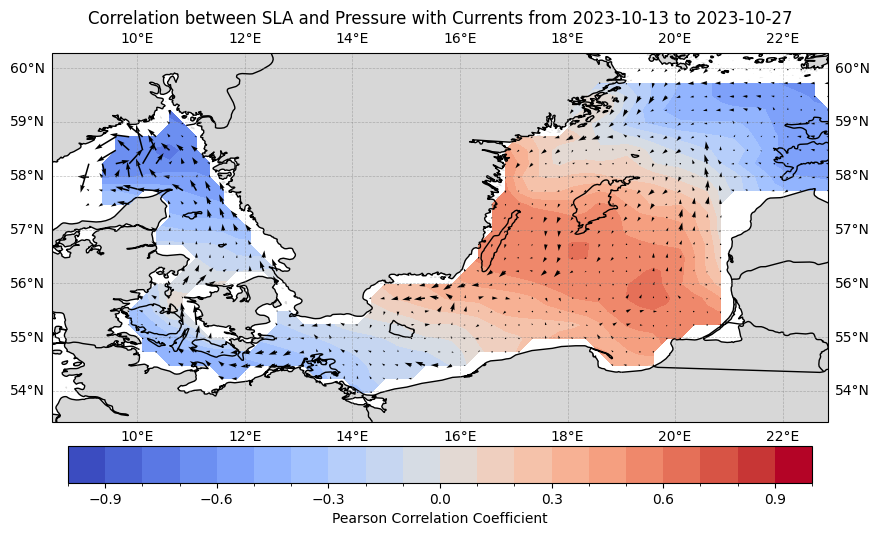

In [59]:
def plot_correlation_with_currents(x, y, u, v, title="Correlation Map (Contour + Currents)"):
    """
    Plots the correlation map as a contour plot with ocean current arrows using Cartopy.

    Parameters:
        x, y (xarray.DataArray): Variables to compute correlation from.
        u, v (xarray.DataArray): Zonal (uo) and meridional (vo) current components.
        title (str): Title of the plot.
    """
    correlation_map = pearson_r(x, y)

    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Konturplot
    correlation_map.plot.contourf(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap='coolwarm',
        levels=21,
        vmin=-1,
        vmax=1,
        cbar_kwargs={'label': 'Pearson Correlation Coefficient',
                     'orientation': 'horizontal', 'shrink': 0.8, 'pad': 0.05},
    )

    # Subsampling für bessere Übersicht
    step = 1
    u_sub = u.isel(latitude=slice(None, None, step), longitude=slice(None, None, step))
    v_sub = v.isel(latitude=slice(None, None, step), longitude=slice(None, None, step))

    # Gitterkoordinaten extrahieren
    lat_sub = u_sub.latitude.values
    lon_sub = u_sub.longitude.values
    lon2d, lat2d = np.meshgrid(lon_sub, lat_sub)

    # Quiver-Pfeile plotten (auf 2D-Arrays achten!)
    ax.quiver(
        lon2d,
        lat2d,
        u_sub.values,
        v_sub.values,
        transform=ccrs.PlateCarree(),
        scale=10,  # Anpassen nach Daten
        width=0.002,
        color='black'
    )

    # Zusätzliche Kartenfeatures
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND, facecolor='lightgrey', alpha=0.9)
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    ax.set_title(title)
    plt.show()

u_mean = ds_merged_sub['uo'].mean(dim='time')
v_mean = ds_merged_sub['vo'].mean(dim='time')


plot_correlation_with_currents(
    ds_merged_sub['sla'],
    ds_merged_sub['pressure_msl'],
    u_mean,
    v_mean,
    title=f"Correlation between SLA and Pressure with Currents from {time_string}"
)

In [54]:
dd

NameError: name 'dd' is not defined

In [ ]:
ds_merged_sub

<xarray.Dataset> Size: 26MB
Dimensions:                     (time: 72, latitude: 26, longitude: 56)
Coordinates:
  * time                        (time) datetime64[ns] 576B 2023-10-19 ... 202...
  * latitude                    (latitude) float64 208B 53.72 53.97 ... 59.97
  * longitude                   (longitude) float64 448B 9.097 9.347 ... 22.85
Data variables: (12/31)
    bottomT                     (time, latitude, longitude) float64 839kB nan...
    mlotst                      (time, latitude, longitude) float64 839kB nan...
    siconc                      (time, latitude, longitude) float64 839kB nan...
    sithick                     (time, latitude, longitude) float64 839kB nan...
    sla                         (time, latitude, longitude) float64 839kB nan...
    so                          (time, latitude, longitude) float64 839kB nan...
    ...                          ...
    cloud_cover_high            (time, latitude, longitude) float64 839kB nan...
    et0_fao_evapotranspiration  (time, latitude, longitude) float64 839kB nan...
    vapour_pressure_deficit     (time, latitude, longitude) float64 839kB nan...
    wind_speed_10m              (time, latitude, longitude) float64 839kB nan...
    wind_direction_10m          (time, latitude, longitude) float64 839kB nan...
    wind_gusts_10m              (time, latitude, longitude) float64 839kB nan...

In [ ]:
ds_merged_sub

<xarray.Dataset> Size: 26MB
Dimensions:                     (time: 72, latitude: 26, longitude: 56)
Coordinates:
  * time                        (time) datetime64[ns] 576B 2023-10-19 ... 202...
  * latitude                    (latitude) float64 208B 53.72 53.97 ... 59.97
  * longitude                   (longitude) float64 448B 9.097 9.347 ... 22.85
Data variables: (12/31)
    bottomT                     (time, latitude, longitude) float64 839kB nan...
    mlotst                      (time, latitude, longitude) float64 839kB nan...
    siconc                      (time, latitude, longitude) float64 839kB nan...
    sithick                     (time, latitude, longitude) float64 839kB nan...
    sla                         (time, latitude, longitude) float64 839kB nan...
    so                          (time, latitude, longitude) float64 839kB nan...
    ...                          ...
    cloud_cover_high            (time, latitude, longitude) float64 839kB nan...
    et0_fao_evapotranspiration  (time, latitude, longitude) float64 839kB nan...
    vapour_pressure_deficit     (time, latitude, longitude) float64 839kB nan...
    wind_speed_10m              (time, latitude, longitude) float64 839kB nan...
    wind_direction_10m          (time, latitude, longitude) float64 839kB nan...
    wind_gusts_10m              (time, latitude, longitude) float64 839kB nan...

In [ ]:
import numpy as np
import xarray as xr

def select_nearest_valid_point(ds, variable_name, target_lat, target_lon):
    """
    Wähle den nächstgelegenen gültigen Punkt (nicht-NaN) im Dataset für eine bestimmte Variable.
    
    Parameters:
        ds (xr.Dataset): Das Eingabe-Dataset mit latitude, longitude, und time-Dimensionen.
        variable_name (str): Name der Variable zur Prüfung auf Gültigkeit (z.B. 'wind_speed_10m').
        target_lat (float): Ziel-Breitengrad.
        target_lon (float): Ziel-Längengrad.

    Returns:
        xr.Dataset: Subset des ursprünglichen Datasets an der nächsten gültigen Position.
        float: Breitengrad der gültigen Position.
        float: Längengrad der gültigen Position.
    """
    # Maske gültiger Punkte entlang der Zeitachse
    valid_mask = ds[variable_name].notnull().any(dim='time')

    # 2D-Gitter der Koordinaten
    lat2d, lon2d = np.meshgrid(ds.latitude.values, ds.longitude.values, indexing='ij')

    # Nur gültige Koordinaten extrahieren
    valid_lat_points = lat2d[valid_mask.values]
    valid_lon_points = lon2d[valid_mask.values]

    # Distanzberechnung (euklidisch)
    distances = np.sqrt((valid_lat_points - target_lat)**2 + (valid_lon_points - target_lon)**2)

    # Index des nächsten gültigen Punkts
    min_idx = np.argmin(distances)
    nearest_lat = valid_lat_points[min_idx]
    nearest_lon = valid_lon_points[min_idx]

    print(f"Nächstgelegener gültiger Punkt: lat={nearest_lat:.6f}, lon={nearest_lon:.6f}")
    
    return ds.sel(latitude=nearest_lat, longitude=nearest_lon), nearest_lat, nearest_lon



Nächstgelegener gültiger Punkt: lat=55.224953, lon=9.847137


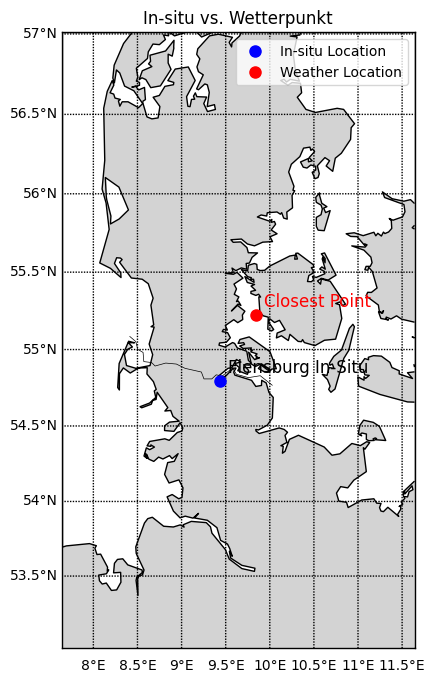

DEPTH  TIME_QC  DEPH  latitude_x  longitude_x      slev  \
time                                                                           
2023-10-13 00:00:00    0.0      1.0   0.0   54.796001        9.434  0.461667   
2023-10-13 01:00:00    0.0      1.0   0.0   54.796001        9.434  0.513333   

                     SLEV_QC    bottomT     mlotst  siconc  sithick       sla  \
time                                                                            
2023-10-13 00:00:00      1.0  12.858720  10.330974     0.0      0.0  0.045590   
2023-10-13 01:00:00      1.0  12.857929  10.051718     0.0      0.0  0.157748   

                            so        sob     thetao        uo        vo  \
time                                                                       
2023-10-13 00:00:00  18.601494  23.072519  14.876753 -0.064446  0.073692   
2023-10-13 01:00:00  18.570156  23.062543  14.862116 -0.067105  0.081672   

                               wo  latitude_y  longitude_y  temperature_2m  \
time                                                                         
2023-10-13 00:00:00  3.085766e-07   55.224953     9.847137        8.575737   
2023-10-13 01:00:00  1.985941e-07   55.224953     9.847137        8.936964   

                     relative_humidity_2m  dew_point_2m  apparent_temperature  \
time                                                                            
2023-10-13 00:00:00             86.644590      6.448332              6.044410   
2023-10-13 01:00:00             85.999769      6.670318              6.452817   

                     precipitation  rain  showers  snowfall  weather_code  \
time                                                                        
2023-10-13 00:00:00            0.0   0.0      0.0       0.0           3.0   
2023-10-13 01:00:00            0.0   0.0      0.0       0.0           3.0   

                     pressure_msl  surface_pressure  cloud_cover  \
time                                                               
2023-10-13 00:00:00   1011.503952       1009.039589    92.618337   
2023-10-13 01:00:00   1010.923987       1008.457228   100.000000   

                     cloud_cover_low  cloud_cover_mid  cloud_cover_high  \
time                                                                      
2023-10-13 00:00:00        26.606060              0.0         41.167438   
2023-10-13 01:00:00        51.167069              0.0        100.000000   

                     et0_fao_evapotranspiration  vapour_pressure_deficit  \
time                                                                       
2023-10-13 00:00:00                    0.005211                 0.154128   
2023-10-13 01:00:00                    0.006655                 0.168680   

                     wind_speed_10m  wind_direction_10m  wind_gusts_10m  
time                                                                     
2023-10-13 00:00:00       11.219222          151.190197       14.255576  
2023-10-13 01:00:00       11.250815          146.240569       18.043660

DEPTH  TIME_QC  DEPH  latitude_x  longitude_x      slev  \
time                                                                           
2023-10-27 22:00:00    0.0      1.0   0.0   54.796001        9.434  0.443333   
2023-10-27 23:00:00    0.0      1.0   0.0   54.796001        9.434  0.470000   

                     SLEV_QC    bottomT     mlotst  siconc  sithick       sla  \
time                                                                            
2023-10-27 22:00:00      1.0  11.601597  10.492398     0.0      0.0  0.107320   
2023-10-27 23:00:00      1.0  11.595865  10.550647     0.0      0.0  0.128922   

                            so        sob     thetao        uo        vo  \
time                                                                       
2023-10-27 22:00:00  19.533445  20.243929  11.276642 -0.065322  0.034800   
2023-10-27 23:00:00  19.542478  20.241896  11.267901 -0.066854  0.040683   

                           wo  latitude_y  longitude_y  temperature_2m  \
time                                                                     
2023-10-27 22:00:00 -0.000004   55.224953     9.847137        7.140611   
2023-10-27 23:00:00 -0.000003   55.224953     9.847137        7.087670   

                     relative_humidity_2m  dew_point_2m  apparent_temperature  \
time                                                                            
2023-10-27 22:00:00             84.823099      4.749841              2.760320   
2023-10-27 23:00:00             84.761682      4.689984              2.782073   

                     precipitation      rain  showers  snowfall  weather_code  \
time                                                                            
2023-10-27 22:00:00       0.026561  0.026561      0.0       0.0     15.749293   
2023-10-27 23:00:00       0.026561  0.026561      0.0       0.0     15.749293   

                     pressure_msl  surface_pressure  cloud_cover  \
time                                                               
2023-10-27 22:00:00    998.769393        996.322172        100.0   
2023-10-27 23:00:00    998.728640        996.281494        100.0   

                     cloud_cover_low  cloud_cover_mid  cloud_cover_high  \
time                                                                      
2023-10-27 22:00:00        66.006983        92.349060         99.466326   
2023-10-27 23:00:00        76.084358        92.995187         98.164818   

                     et0_fao_evapotranspiration  vapour_pressure_deficit  \
time                                                                       
2023-10-27 22:00:00                    0.015516                 0.155000   
2023-10-27 23:00:00                    0.014914                 0.154863   

                     wind_speed_10m  wind_direction_10m  wind_gusts_10m  
time                                                                     
2023-10-27 22:00:00        21.33671           89.021992       35.215880  
2023-10-27 23:00:00        20.73866           90.669411       35.170056

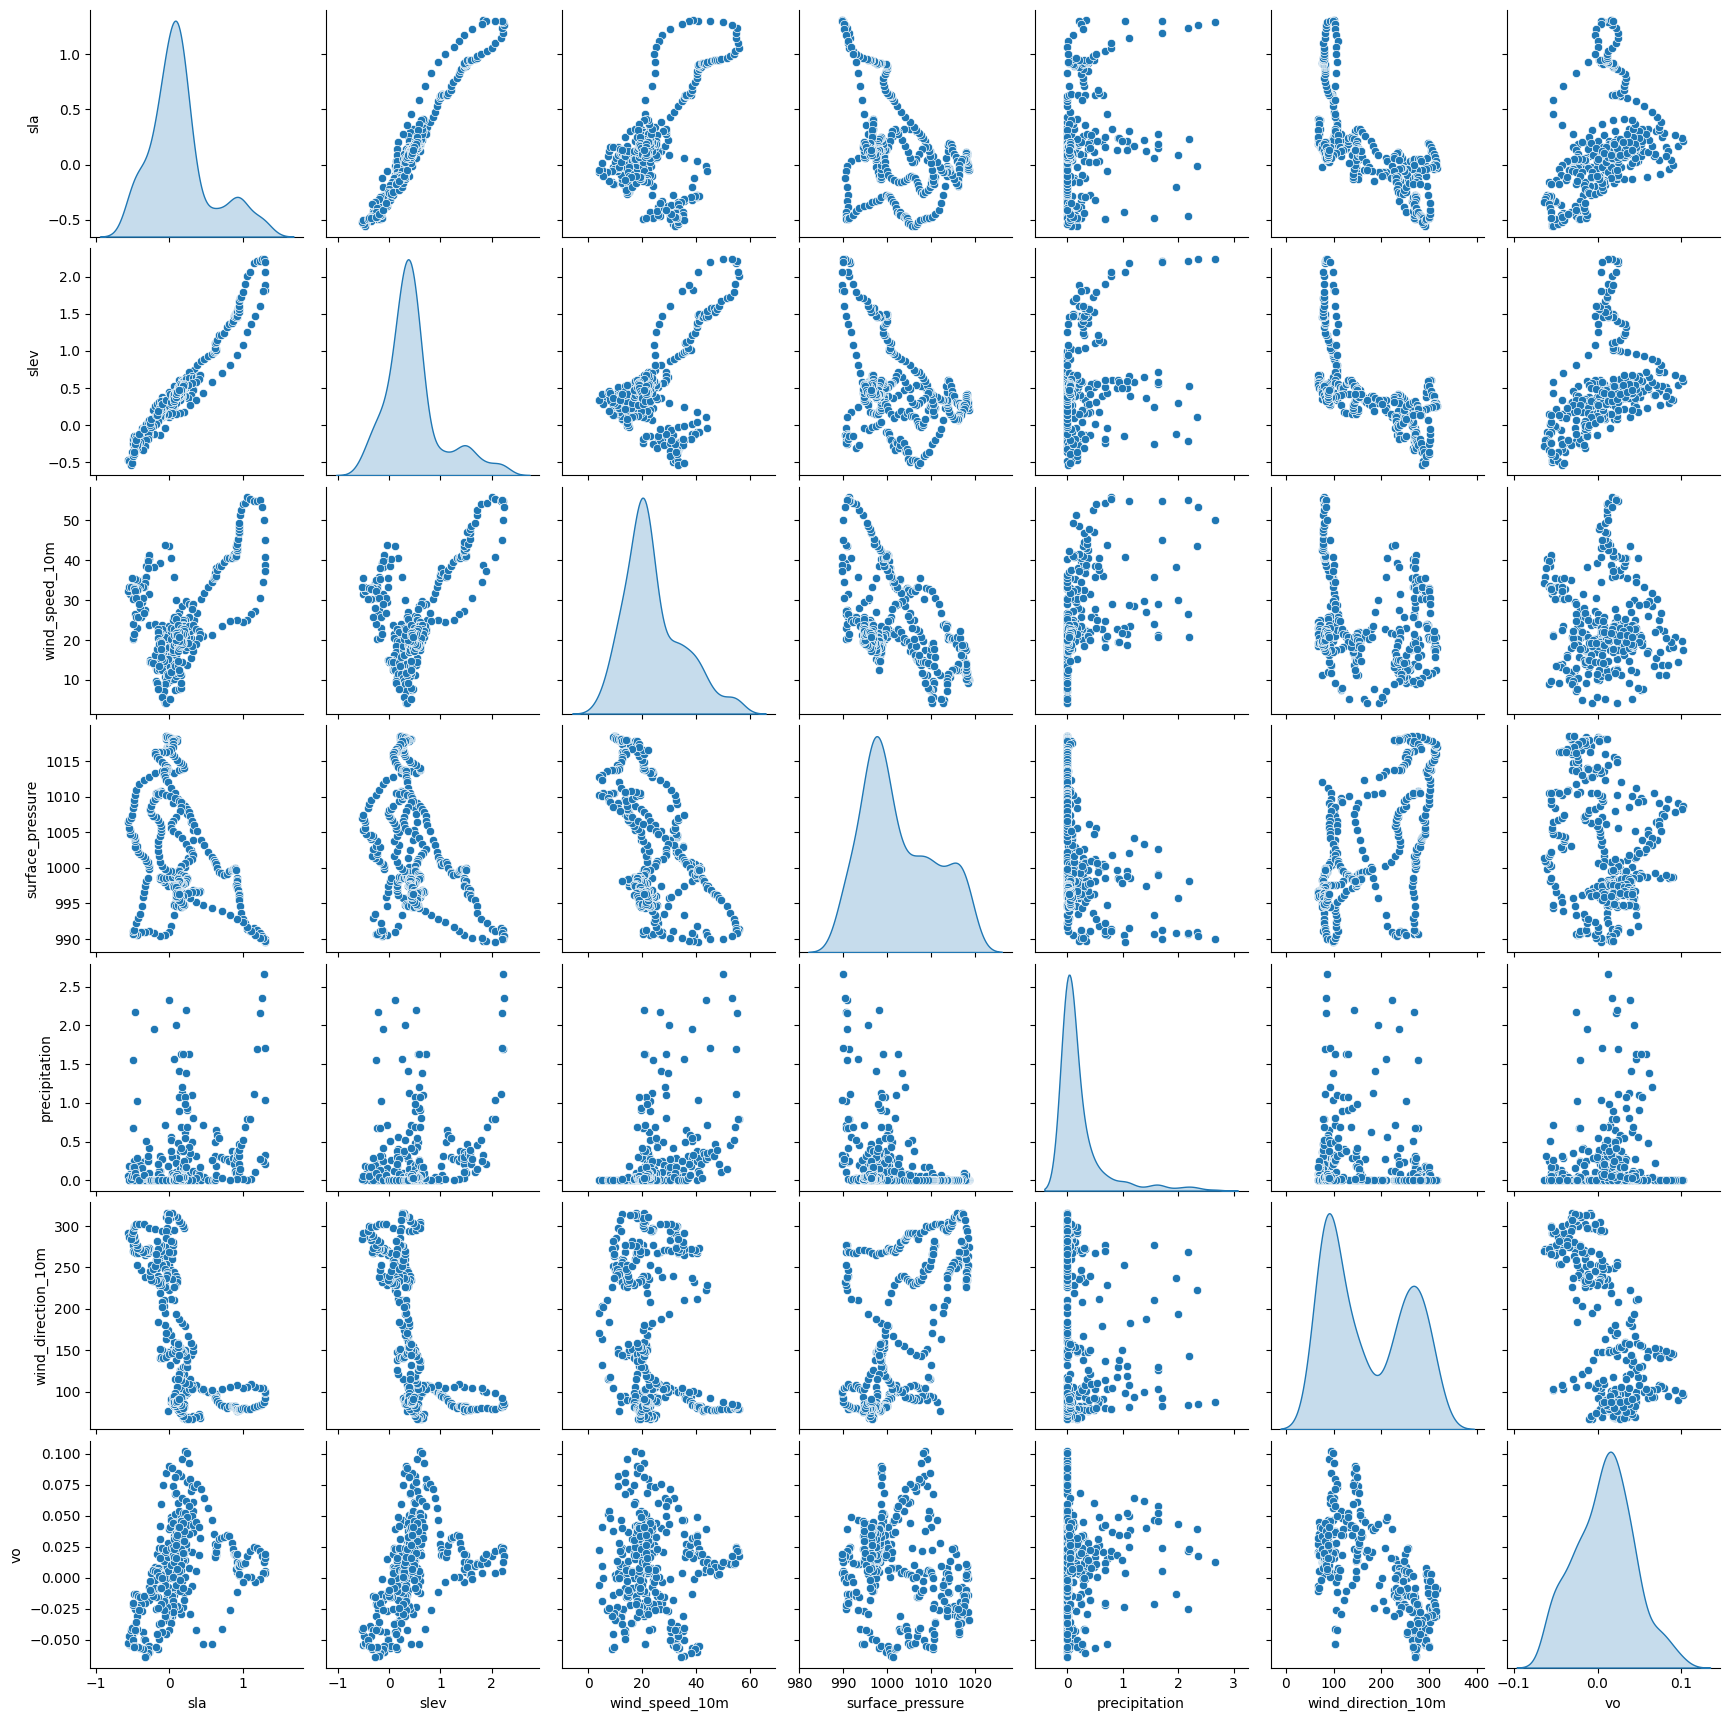

Korrelationsmatrix:


slev                          1.000000
sla                           0.970859
mlotst                        0.552607
wind_speed_10m                0.519678
cloud_cover_low               0.507840
cloud_cover                   0.507286
wind_gusts_10m                0.496300
cloud_cover_mid               0.480178
weather_code                  0.435368
cloud_cover_high              0.412632
vo                            0.401707
rain                          0.308531
precipitation                 0.308531
relative_humidity_2m          0.216219
so                            0.189013
bottomT                       0.141322
et0_fao_evapotranspiration   -0.170040
dew_point_2m                 -0.182626
thetao                       -0.285583
vapour_pressure_deficit      -0.313381
pressure_msl                 -0.358916
surface_pressure             -0.360097
temperature_2m               -0.413962
apparent_temperature         -0.574266
sob                          -0.586665
uo                       

['slev', 'sla', 'mlotst', 'wind_speed_10m', 'cloud_cover_low', 'cloud_cover', 'wind_gusts_10m', 'cloud_cover_mid', 'weather_code', 'cloud_cover_high', 'wo', 'wind_direction_10m', 'uo', 'sob', 'apparent_temperature', 'temperature_2m', 'surface_pressure', 'pressure_msl', 'vapour_pressure_deficit', 'thetao']


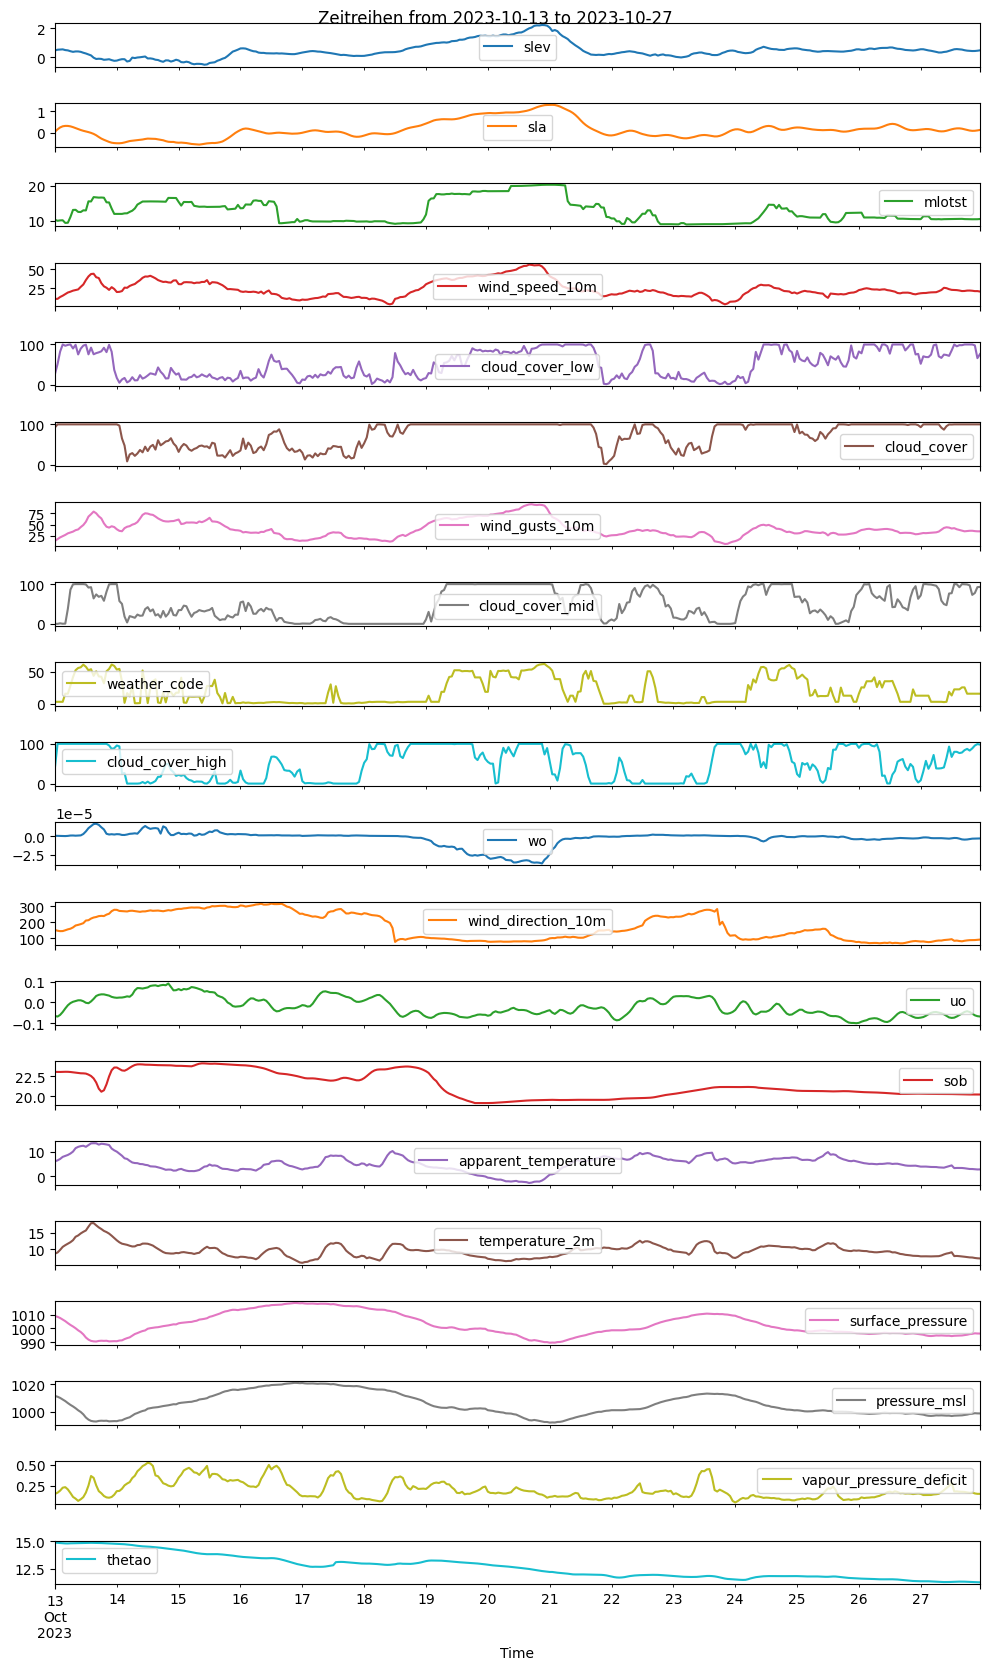


Regressionskoeffizienten:
sla: 1.9928
mlotst: -0.0954
wind_speed_10m: 1.3183
cloud_cover_low: -0.1010
cloud_cover: -0.0314
wind_gusts_10m: 0.4672
cloud_cover_mid: 0.0057
weather_code: 0.0186
cloud_cover_high: 0.0148
wo: -0.9022
wind_direction_10m: 0.2160
uo: -0.2550
sob: 0.2936
apparent_temperature: 3.3851
temperature_2m: -3.1002
surface_pressure: -20.3042
pressure_msl: 20.2377
vapour_pressure_deficit: 0.2501
thetao: -0.2819
R² Score: 0.9764


In [76]:
import pandas as pd
import xarray as xr
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mpl_toolkits.basemap import Basemap

# === 1. In-situ Daten laden ===
def load_insitu_data(filepath):
    ds = xr.open_dataset(filepath)
    df = ds.to_dataframe().reset_index()
    return df.rename(columns={
        "TIME": "time",
        "SLEV": "slev",
        "LATITUDE": "latitude",
        "LONGITUDE": "longitude"
    })

insitu_path = Path("../data/observation/NO_TS_TG_FlensburgTG.nc")
df_insitu = load_insitu_data(insitu_path)
insitu_location = (df_insitu.latitude.iloc[0], df_insitu.longitude.iloc[0])

# Get the nearest valid point in xarray to Flensburg
flensburg_ds, nearest_lat, nearest_lon = select_nearest_valid_point(ds_merged_sub, 'wind_speed_10m', 54.796001, 9.434)



# === 2. Wetterdaten vorbereiten ===
# Stelle sicher, dass flensburg_ds vorher korrekt definiert ist
wetter_df = flensburg_ds.to_dataframe().reset_index().set_index("time")
wetter_location = (wetter_df.latitude.iloc[0], wetter_df.longitude.iloc[0])


# === 3. Karte mit Basemap zeichnen ===
def plot_locations(insitu_loc, weather_loc):
    center_lat = (insitu_loc[0] + weather_loc[0]) / 2
    center_lon = (insitu_loc[1] + weather_loc[1]) / 2

    plt.figure(figsize=(10, 8))
    m = Basemap(projection='merc',
                llcrnrlat=center_lat - 2, urcrnrlat=center_lat + 2,
                llcrnrlon=center_lon - 2, urcrnrlon=center_lon + 2,
                resolution='i')

    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='white')
    m.fillcontinents(color='lightgray', lake_color='white')
    m.drawparallels(np.arange(0., 90., 0.5), labels=[1,0,0,0])
    m.drawmeridians(np.arange(0., 180., 0.5), labels=[0,0,0,1])

    x_insitu, y_insitu = m(insitu_loc[1], insitu_loc[0])
    x_weather, y_weather = m(weather_loc[1], weather_loc[0])

    m.plot(x_insitu, y_insitu, 'bo', markersize=8, label='In-situ Location')
    m.plot(x_weather, y_weather, 'ro', markersize=8, label='Weather Location')

    plt.text(x_insitu+10000, y_insitu+10000, 'Flensburg In-Situ', fontsize=12, color='black')
    plt.text(x_weather+10000, y_weather+10000, 'Closest Point', fontsize=12, color='red')

    plt.legend()
    plt.title('In-situ vs. Wetterpunkt')
    plt.show()

plot_locations(insitu_location, wetter_location)

# === 4. Zeitliche Synchronisierung ===
df_insitu = df_insitu.set_index("time").resample("h").mean(numeric_only=True)
wetter_df = wetter_df.resample("h").mean()

# === 5. Daten zusammenführen ===
merged_df = pd.merge(df_insitu, wetter_df, left_index=True, right_index=True, how="inner")
display(merged_df.head(2))
display(merged_df.tail(2))

# === 6. Explorative Analyse ===
features = ['sla', 'slev', 'wind_speed_10m', 'surface_pressure', 'precipitation', 'wind_direction_10m', 'vo']
#features = merged_df.columns.tolist()


sns.pairplot(merged_df[features], diag_kind='kde')
plt.show()

# === 7. Korrelationen anzeigen ===
correlation = merged_df.corr(numeric_only=True)
print("Korrelationsmatrix:")
display(correlation["slev"].sort_values(ascending=False))

# 10 grö0te Korrelationen
features = correlation["slev"].sort_values(ascending=False).nlargest(10).index.tolist()
features += correlation["slev"].sort_values(ascending=False).nsmallest(10).index.tolist()
print(features)

# === 8. Zeitreihenvisualisierung ===
merged_df[features].plot(
    subplots=True, figsize=(10, 17), title=f"Zeitreihen from {time_string}")
plt.tight_layout()
plt.legend(loc='upper left')
plt.xlabel("Time")
plt.show()

# === 9. Lineare Regression ===
def run_regression(df, target_col, feature_cols):
    X = df[feature_cols]
    y = df[target_col]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    #X_scaled = X

    model = LinearRegression()
    model.fit(X_scaled, y)

    print("\nRegressionskoeffizienten:")
    for feat, coef in zip(feature_cols, model.coef_):
        print(f"{feat}: {coef:.4f}")
    print(f"R² Score: {model.score(X_scaled, y):.4f}")

run_regression(merged_df, "slev", features[1:])


In [57]:
features

['sla',
 'slev',
 'wind_speed_10m',
 'surface_pressure',
 'precipitation',
 'wind_direction_10m',
 'vo']

In [ ]:
ds_merged_sub_sub

<xarray.Dataset> Size: 576B
Dimensions:                     (time: 72, latitude: 0, longitude: 0)
Coordinates:
  * time                        (time) datetime64[ns] 576B 2023-10-19 ... 202...
  * latitude                    (latitude) float64 0B 
  * longitude                   (longitude) float64 0B 
Data variables: (12/31)
    bottomT                     (time, latitude, longitude) float64 0B 
    mlotst                      (time, latitude, longitude) float64 0B 
    siconc                      (time, latitude, longitude) float64 0B 
    sithick                     (time, latitude, longitude) float64 0B 
    sla                         (time, latitude, longitude) float64 0B 
    so                          (time, latitude, longitude) float64 0B 
    ...                          ...
    cloud_cover_high            (time, latitude, longitude) float64 0B 
    et0_fao_evapotranspiration  (time, latitude, longitude) float64 0B 
    vapour_pressure_deficit     (time, latitude, longitude) float64 0B 
    wind_speed_10m              (time, latitude, longitude) float64 0B 
    wind_direction_10m          (time, latitude, longitude) float64 0B 
    wind_gusts_10m              (time, latitude, longitude) float64 0B

In [ ]:
dd

NameError: name 'dd' is not defined

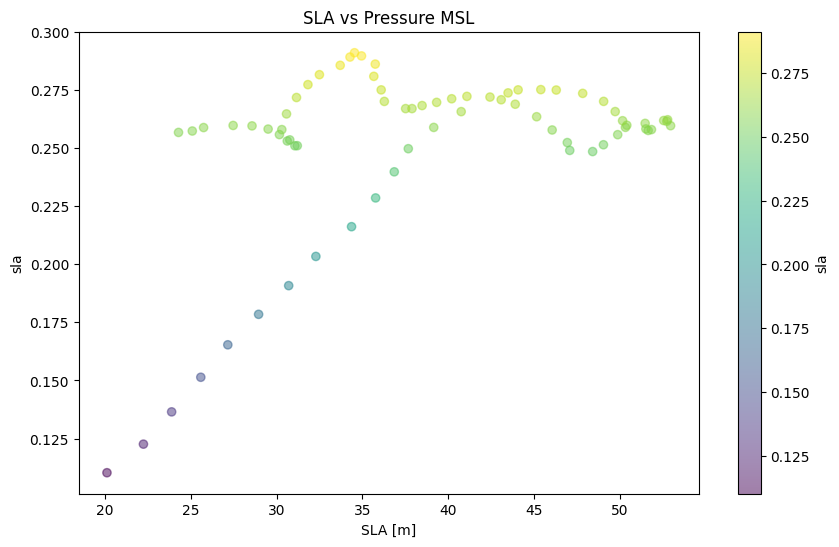

In [48]:
def plot_scatter(ds_merged, x_col, y_col, c, title, xlabel, ylabel, dim=['latitude', 'longitude']):
    plt.figure(figsize=(10, 6))
    plt.scatter(ds_merged[x_col].mean(dim=dim), ds_merged[y_col].mean(dim=dim), c=ds_merged[c].mean(dim=dim), cmap='viridis', alpha=0.5)
    plt.colorbar(label=c)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

plot_scatter(ds_merged=ds_merged_sub, 
             x_col='wind_speed_10m', 
             y_col='sla',
             c='sla',
            title='SLA vs Pressure MSL',
            xlabel='SLA [m]',
            ylabel='sla',
            )


# col1 = ds_merged['sla'].mean(dim=['latitude', 'longitude'])
# col2 = ds_merged['wind_speed_10m'].mean(dim=['latitude', 'longitude'])

# plt.scatter(col1, col2, alpha=0.5, marker='o', cmap='viridis', c=ds_merged['wind_direction_10m'].mean(dim=['latitude', 'longitude']))
# plt.xlabel('mean SLA [m]')
# plt.ylabel('mean Wind Speed [m/s]')
# plt.show()


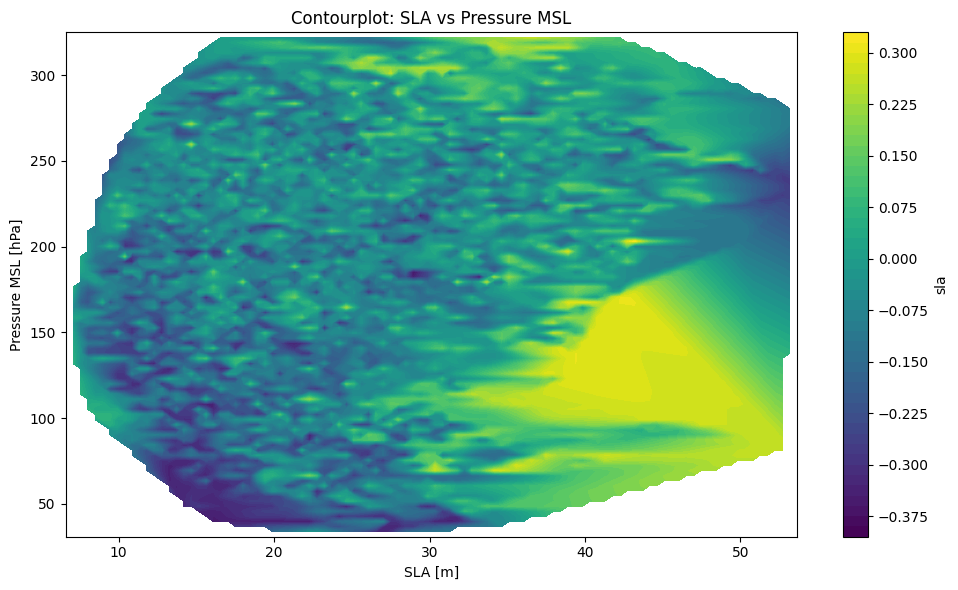

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

def plot_contour(ds_merged, x_col, y_col, c, title, xlabel, ylabel, bins=500, dim=['latitude', 'longitude']):
    """
    Erzeugt einen Contourplot von Mittelwerten über angegebene Dimensionen (z. B. lat/lon).
    """
    # Mittelwerte über Raumdimensionen
    x = ds_merged[x_col].mean(dim=dim).values.flatten()
    y = ds_merged[y_col].mean(dim=dim).values.flatten()
    z = ds_merged[c].mean(dim=dim).values.flatten()

    # Entferne NaNs
    mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(z)
    x, y, z = x[mask], y[mask], z[mask]

    # Erzeuge ein 2D-Gitter durch Histogramm-Binning
    xi = np.linspace(np.min(x), np.max(x), bins)
    yi = np.linspace(np.min(y), np.max(y), bins)
    Xi, Yi = np.meshgrid(xi, yi)

    # Interpolation der Z-Werte auf das Gitter
    from scipy.interpolate import griddata
    Zi = griddata((x, y), z, (Xi, Yi), method='linear')

    # Plot
    plt.figure(figsize=(10, 6))
    contour = plt.contourf(Xi, Yi, Zi, levels=50, cmap='viridis')
    cbar = plt.colorbar(contour)
    cbar.set_label(c)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

plot_contour(ds_merged=ds_merged, 
             x_col='wind_speed_10m', 
             y_col='wind_direction_10m',
             c='sla',
             title='Contourplot: SLA vs Pressure MSL',
             xlabel='SLA [m]',
             ylabel='Pressure MSL [hPa]',
             bins=100,
            )


In [ ]:
dd

NameError: name 'dd' is not defined

In [ ]:
ds_interp = ds_weather.interpolate_na(dim="latitude", method="linear")
ds_interp = ds_interp.interpolate_na(dim="longitude", method="linear")
ds_interp

<xarray.Dataset> Size: 2GB
Dimensions:                     (time: 20184, latitude: 10, longitude: 99)
Coordinates:
  * time                        (time) datetime64[ns] 161kB 2022-12-03 ... 20...
  * latitude                    (latitude) float32 40B 53.53 54.24 ... 59.3 60.0
  * longitude                   (longitude) float32 396B 8.979 9.12 ... 23.1
Data variables: (12/20)
    temperature_2m              (time, latitude, longitude) float32 80MB nan ...
    relative_humidity_2m        (time, latitude, longitude) float32 80MB nan ...
    dew_point_2m                (time, latitude, longitude) float32 80MB nan ...
    apparent_temperature        (time, latitude, longitude) float32 80MB nan ...
    precipitation               (time, latitude, longitude) float32 80MB nan ...
    rain                        (time, latitude, longitude) float32 80MB nan ...
    ...                          ...
    cloud_cover_high            (time, latitude, longitude) float32 80MB nan ...
    et0_fao_evapotranspiration  (time, latitude, longitude) float32 80MB nan ...
    vapour_pressure_deficit     (time, latitude, longitude) float32 80MB nan ...
    wind_speed_10m              (time, latitude, longitude) float32 80MB nan ...
    wind_direction_10m          (time, latitude, longitude) float32 80MB nan ...
    wind_gusts_10m              (time, latitude, longitude) float32 80MB nan ...

In [ ]:
import numpy as np

# Altes Gitter
old_lats = ds_interp.latitude
old_lons = ds_interp.longitude

# Neues feineres Gitter erzeugen (z. B. 0.25° statt 1.0° Auflösung)
new_lats = np.arange(old_lats.min(), old_lats.max(), 0.25)
new_lons = np.arange(old_lons.min(), old_lons.max(), 0.25)

# Interpolation
ds_interp = ds_interp.interp(latitude=new_lats, longitude=new_lons, method='linear')


In [ ]:
ds_interp

<xarray.Dataset> Size: 5GB
Dimensions:                     (time: 20184, latitude: 26, longitude: 57)
Coordinates:
  * time                        (time) datetime64[ns] 161kB 2022-12-03 ... 20...
  * latitude                    (latitude) float64 208B 53.53 53.78 ... 59.78
  * longitude                   (longitude) float64 456B 8.979 9.229 ... 22.98
Data variables: (12/20)
    temperature_2m              (time, latitude, longitude) float64 239MB nan...
    relative_humidity_2m        (time, latitude, longitude) float64 239MB nan...
    dew_point_2m                (time, latitude, longitude) float64 239MB nan...
    apparent_temperature        (time, latitude, longitude) float64 239MB nan...
    precipitation               (time, latitude, longitude) float64 239MB nan...
    rain                        (time, latitude, longitude) float64 239MB nan...
    ...                          ...
    cloud_cover_high            (time, latitude, longitude) float64 239MB nan...
    et0_fao_evapotranspiration  (time, latitude, longitude) float64 239MB nan...
    vapour_pressure_deficit     (time, latitude, longitude) float64 239MB nan...
    wind_speed_10m              (time, latitude, longitude) float64 239MB nan...
    wind_direction_10m          (time, latitude, longitude) float64 239MB nan...
    wind_gusts_10m              (time, latitude, longitude) float64 239MB nan...

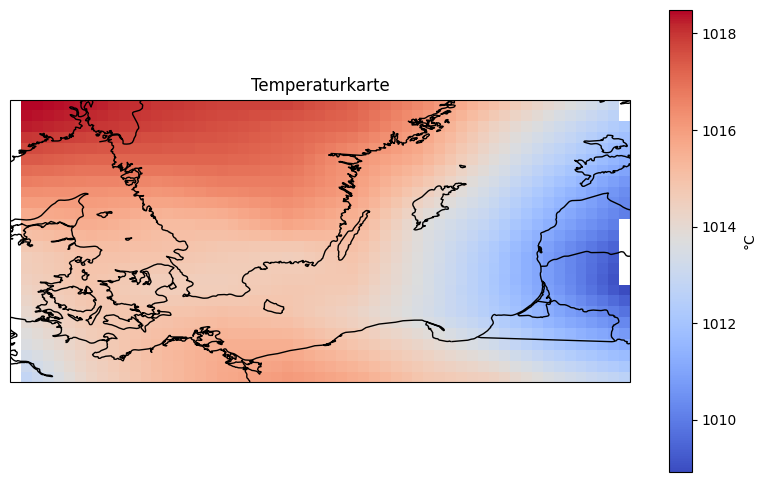

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Beispiel: Temperatur auswählen
temperature = ds_interp['pressure_msl'].sel(time='2023-10-18T12:00:00')

# Plot
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # oder z. B. ccrs.Mercator()

temperature.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', cbar_kwargs={'label': '°C'})

# Extras: Küstenlinien etc.
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title("Temperaturkarte")

plt.show()


/gxfs_home/geomar/smomw693/venv/.main/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


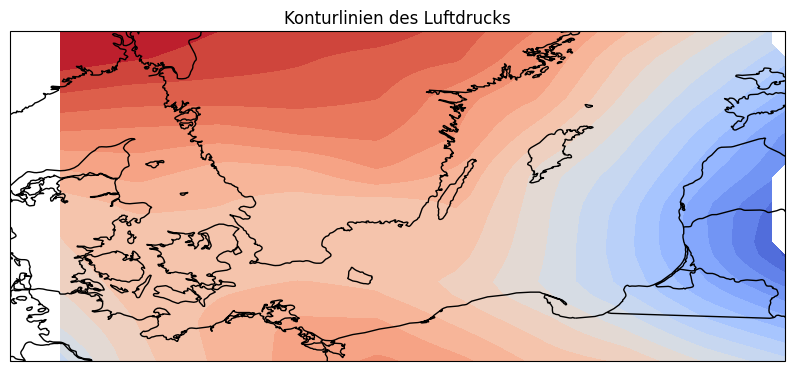

In [ ]:
temperature = ds_interp['pressure_msl'].sel(time='2023-10-18T12:00:00')

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# Konturlinien
cs = ax.contourf(temperature.longitude, temperature.latitude, temperature, 
                 levels=20, cmap='coolwarm',  # <- Korrektur hier
                 linewidths=1, transform=ccrs.PlateCarree())


ax.set_title("Konturlinien des Luftdrucks")
plt.show()


In [ ]:
ds_interp

<xarray.Dataset> Size: 5GB
Dimensions:                     (time: 20184, latitude: 26, longitude: 57)
Coordinates:
  * time                        (time) datetime64[ns] 161kB 2022-12-03 ... 20...
  * latitude                    (latitude) float64 208B 53.53 53.78 ... 59.78
  * longitude                   (longitude) float64 456B 8.979 9.229 ... 22.98
Data variables: (12/20)
    temperature_2m              (time, latitude, longitude) float64 239MB nan...
    relative_humidity_2m        (time, latitude, longitude) float64 239MB nan...
    dew_point_2m                (time, latitude, longitude) float64 239MB nan...
    apparent_temperature        (time, latitude, longitude) float64 239MB nan...
    precipitation               (time, latitude, longitude) float64 239MB nan...
    rain                        (time, latitude, longitude) float64 239MB nan...
    ...                          ...
    cloud_cover_high            (time, latitude, longitude) float64 239MB nan...
    et0_fao_evapotranspiration  (time, latitude, longitude) float64 239MB nan...
    vapour_pressure_deficit     (time, latitude, longitude) float64 239MB nan...
    wind_speed_10m              (time, latitude, longitude) float64 239MB nan...
    wind_direction_10m          (time, latitude, longitude) float64 239MB nan...
    wind_gusts_10m              (time, latitude, longitude) float64 239MB nan...

In [ ]:
u = ds_interp['u10'].sel(time='2023-10-18T12:00:00')  # Ost-Komponente
v = ds_interp['v10'].sel(time='2023-10-18T12:00:00')  # Nord-Komponente

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# Vektorpfeile (Wind)
q = ax.quiver(u.lon[::5], u.lat[::5], u[::5, ::5], v[::5, ::5], transform=ccrs.PlateCarree(), scale=700)

ax.set_title("Windvektoren")
plt.show()


KeyError: "No variable named 'u10'. Variables on the dataset include ['time', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature', ..., 'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m', 'latitude', 'longitude']"

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

ax.streamplot(u.lon, u.lat, u.values, v.values, transform=ccrs.PlateCarree(), color='blue', density=1.5)
ax.set_title("Stromlinien der Windrichtung")
plt.show()


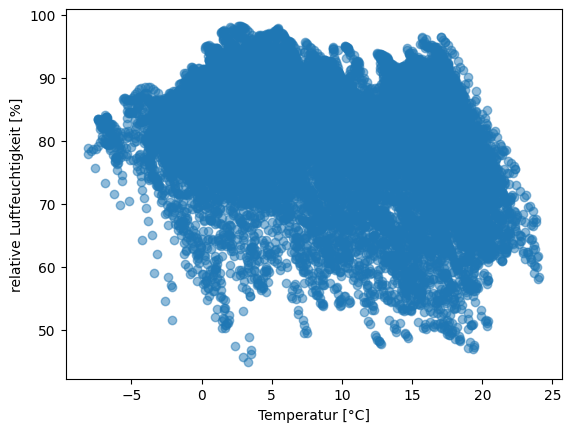

In [ ]:
temp = ds_interp['temperature_2m'].mean(dim=['latitude', 'longitude'])
humidity = ds_interp['relative_humidity_2m'].mean(dim=['latitude', 'longitude'])

plt.scatter(temp, humidity, alpha=0.5)
plt.xlabel('Temperatur [°C]')
plt.ylabel('relative Luftfeuchtigkeit [%]')
plt.show()


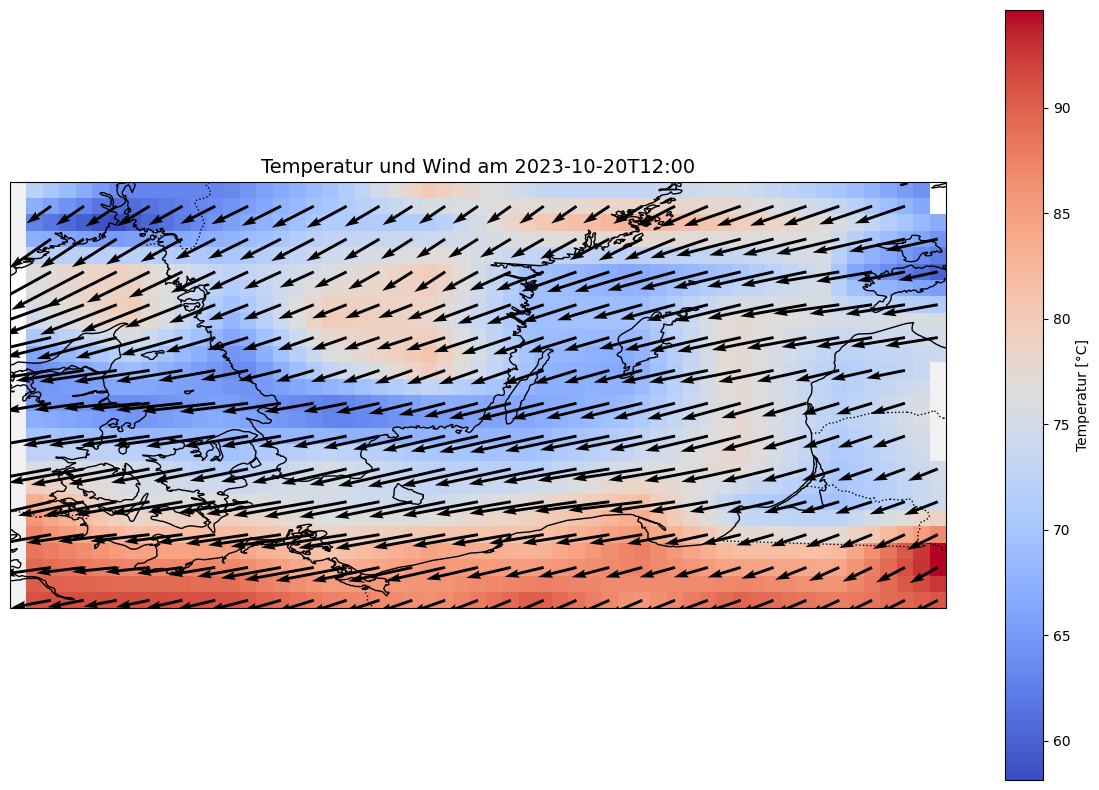

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Beispielzeitpunkt auswählen
time_sel = '2023-10-20T12:00'

# Daten selektieren
temp = ds_interp['relative_humidity_2m'].sel(time=time_sel)
wind_speed = ds_interp['wind_speed_10m'].sel(time=time_sel)
wind_dir = ds_interp['wind_direction_10m'].sel(time=time_sel)

# Windrichtung und -geschwindigkeit → u, v-Komponenten umrechnen
wind_u = wind_speed * -np.sin(np.deg2rad(wind_dir))
wind_v = wind_speed * -np.cos(np.deg2rad(wind_dir))

# Plot erstellen
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Temperaturkarte (colormap)
temp.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', cbar_kwargs={'label': 'Temperatur [°C]'})

# Küstenlinie, Ländergrenzen etc.
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)

# Windvektoren
# Downsamplen für bessere Übersicht (z. B. jeden 3. Punkt)
step = 2
lat = ds_interp.latitude[::step]
lon = ds_interp.longitude[::step]
u = wind_u[::step, ::step]
v = wind_v[::step, ::step]

ax.quiver(lon, lat, u, v, transform=ccrs.PlateCarree(), color='black', scale=700)

# Titel
ax.set_title(f"Temperatur und Wind am {time_sel}", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
dd

NameError: name 'dd' is not defined

# In Situ Data

In [ ]:
insitu_data = 'NO_TS_TG_FlensburgTG.nc'
file_path = Path("../data/observation") / insitu_data
ds_insitu = xr.open_dataset(file_path)

df_insitu = ds_insitu.to_dataframe().reset_index()

In [ ]:
df_insitu = df_insitu.dropna(axis=1, how="all")
df_insitu = df_insitu.dropna(axis=0, how="any")

# Rename columns
df_insitu = df_insitu.rename(
    columns={
        "DEPTH": "depth",
        "LATITUDE": "latitude",
        "LONGITUDE": "longitude",
        "SLEV": "slev",
        "TIME": "time",
    }
)

# filter the data by time from df_ocean
df_insitu = df_insitu[
    (df_insitu["time"] >= df_ocean["time"].min())
    & (df_insitu["time"] <= df_ocean["time"].max())
].reset_index(drop=True)

# Select SLEV_QC = 1
df_insitu = df_insitu[df_insitu["SLEV_QC"] == 1].reset_index(drop=True)

# Group the Data hurly and take the mean
df_insitu.set_index('time', inplace=True)
df_insitu = df_insitu.resample('h').mean(numeric_only=True)
df_insitu.reset_index(inplace=True)

df_insitu = process_df(df_insitu)
df_insitu = df_insitu.drop(columns=["depth"], axis=1)
show_df(df_insitu)

time  TIME_QC  DEPH   latitude  longitude      slev  SLEV_QC
0 2022-12-03 00:00:00      1.0   0.0  54.796001      9.434  0.486667      1.0
1 2022-12-03 01:00:00      1.0   0.0  54.796001      9.434  0.463333      1.0
2 2022-12-03 02:00:00      1.0   0.0  54.796001      9.434  0.373333      1.0
3 2022-12-03 03:00:00      1.0   0.0  54.796001      9.434  0.283333      1.0
4 2022-12-03 04:00:00      1.0   0.0  54.796001      9.434  0.240000      1.0

time  TIME_QC  DEPH   latitude  longitude      slev  \
20156 2025-03-21 20:00:00      1.0   0.0  54.796001      9.434  0.483333   
20157 2025-03-21 21:00:00      1.0   0.0  54.796001      9.434  0.496667   
20158 2025-03-21 22:00:00      1.0   0.0  54.796001      9.434  0.538333   
20159 2025-03-21 23:00:00      1.0   0.0  54.796001      9.434  0.550000   
20160 2025-03-22 00:00:00      1.0   0.0  54.796001      9.434  0.550000   

       SLEV_QC  
20156      1.0  
20157      1.0  
20158      1.0  
20159      1.0  
20160      1.0

Columns: ['time', 'TIME_QC', 'DEPH', 'latitude', 'longitude', 'slev', 'SLEV_QC']
Number of unique coordinates: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20161 entries, 0 to 20160
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       20161 non-null  datetime64[ns]
 1   TIME_QC    20156 non-null  float32       
 2   DEPH       20156 non-null  float32       
 3   latitude   20156 non-null  float32       
 4   longitude  20156 non-null  float32       
 5   slev       20156 non-null  float32       
 6   SLEV_QC    20156 non-null  float32       
dtypes: datetime64[ns](1), float32(6)
memory usage: 630.2 KB
None
time         0
TIME_QC      5
DEPH         5
latitude     5
longitude    5
slev         5
SLEV_QC      5
dtype: int64


time  TIME_QC     DEPH      latitude  \
count                          20161  20156.0  20156.0  20156.000000   
mean   2024-01-26 23:59:59.999999744      1.0      0.0     54.796005   
min              2022-12-03 00:00:00      1.0      0.0     54.796001   
25%              2023-07-01 00:00:00      1.0      0.0     54.796001   
50%              2024-01-27 00:00:00      1.0      0.0     54.796001   
75%              2024-08-24 00:00:00      1.0      0.0     54.796001   
max              2025-03-22 00:00:00      1.0      0.0     54.796001   
std                              NaN      0.0      0.0      0.000000   

       longitude          slev  SLEV_QC  
count  20156.000  20156.000000  20156.0  
mean       9.434      0.113876      1.0  
min        9.434     -1.693333      1.0  
25%        9.434     -0.025000      1.0  
50%        9.434      0.115000      1.0  
75%        9.434      0.248333      1.0  
max        9.434      2.848333      1.0  
std        0.000      0.266060      0.0

Keine fehlenden Zeitpunkte!


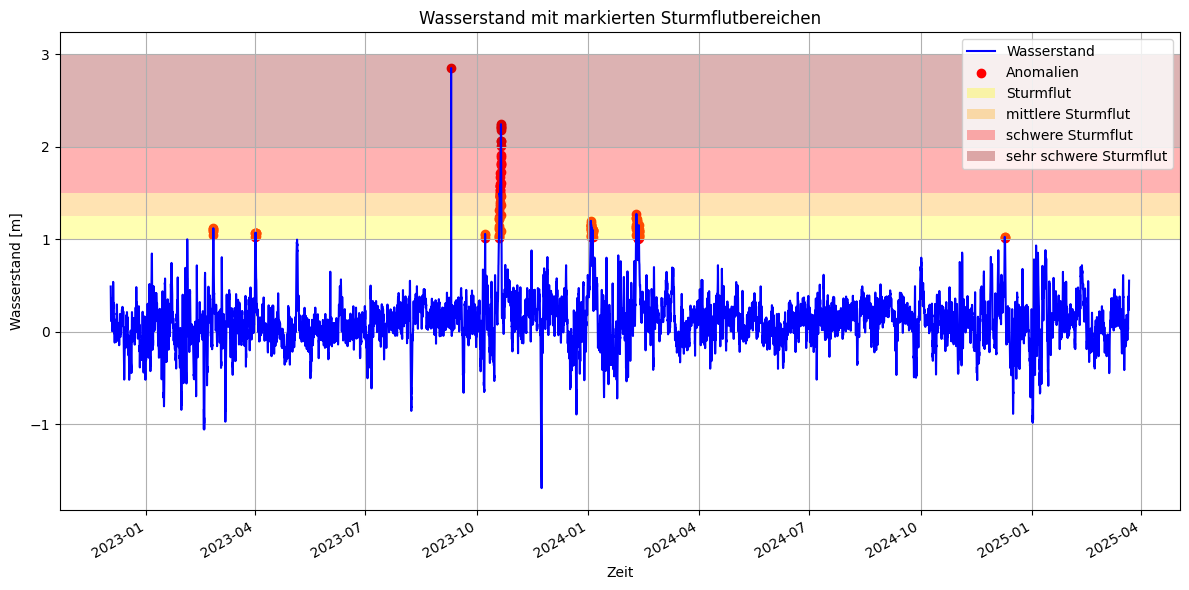

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Anomalien vorbereiten
df_anomalies = df_insitu.copy()
df_anomalies['anomaly'] = (df_anomalies['slev'] > 1.0).astype(int)

# Nur Zeitpunkte mit Anomalien gruppieren
df_anomalies_grouped = (
    df_anomalies[df_anomalies['anomaly'] == 1]
    .groupby('time')[['slev']]
    .mean()
    .reset_index()
)

# Plot erstellen
fig, ax = plt.subplots(figsize=(12, 6))

# Wasserstandslinie
ax.plot(df_anomalies['time'], df_anomalies['slev'], label='Wasserstand', color='blue')

# Anomalien als rote Punkte
ax.scatter(df_anomalies_grouped['time'], df_anomalies_grouped['slev'],
           color='red', label='Anomalien', marker='o')

# Farbige Bereiche für Sturmflutklassen
flood_levels = [
    (1.0, 1.25, 'yellow', 'Sturmflut'),
    (1.25, 1.5, 'orange', 'mittlere Sturmflut'),
    (1.5, 2.0, 'red', 'schwere Sturmflut'),
    (2.0, 3.0, 'darkred', 'sehr schwere Sturmflut'),
]

for y0, y1, color, label in flood_levels:
    ax.axhspan(y0, y1, facecolor=color, alpha=0.3, label=label)

# Annotationen mittig platzieren
# x_center = df_anomalies['time'].median() + pd.Timedelta(days=300)
# print(x_center)
# for y0, y1, color, label in flood_levels:
#     y_text = (y0 + y1) / 2
#     text_color = 'white' if color in ['red', 'darkred'] else 'black'
#     ax.text(x_center, y_text, label, va='center', ha='center',
#             fontsize=10, backgroundcolor=color, color=text_color, alpha=0.7)

# Achsenbeschriftung und Formatierung
ax.set_title("Wasserstand mit markierten Sturmflutbereichen")
ax.set_xlabel("Zeit")
ax.set_ylabel("Wasserstand [m]")
ax.legend(loc='best')
fig.autofmt_xdate()

plt.grid()
plt.tight_layout()
plt.show()


# Merge Dataframes

In [ ]:
import pandas as pd
from joblib import Parallel, delayed

def process_coord(df: pd.DataFrame, coord: tuple) -> pd.DataFrame:
    """
    Processes a subset of the DataFrame for a given coordinate.
    """
    df_sub = df[df['position'] == coord].copy()
    df_sub.drop(columns=['latitude', 'longitude', 'position'], inplace=True)

    value_columns = df_sub.columns.difference(['time'])
    df_sub.rename(
        columns={col: f"{col}_{coord}" for col in value_columns},
        inplace=True
    )

    return df_sub

def convert_df_joblib(df: pd.DataFrame, n_jobs: int = -1) -> pd.DataFrame:
    """
    Converts the DataFrame by pivoting values for unique coordinates
    using parallel processing via joblib.
    """
    df['position'] = list(zip(df['latitude'], df['longitude']))
    unique_coords = df['position'].unique()
    print(f"Number of unique coordinates: {len(unique_coords)}")

    df_merged = pd.DataFrame({'time': df['time'].unique()})

    # Parallel processing
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_coord)(df, coord) for coord in tqdm(unique_coords)
    )

    # Merge all partial DataFrames
    for df_sub in results:
        df_merged = df_merged.merge(df_sub, on='time', how='left')

    return df_merged

# Usage
df_ocean_converted = convert_df_joblib(df_ocean)
df_weather_converted = convert_df_joblib(df_weather)



Number of unique coordinates: 11


100%|██████████| 11/11 [00:00<00:00, 18454.94it/s]

Number of unique coordinates: 100


100%|██████████| 100/100 [00:00<00:00, 54414.95it/s]


In [ ]:
# Merge df_ocean and df_weather and df_insitu
df_merged = df_ocean_converted.merge(df_weather_converted, on='time', how='inner')
df_merged = df_merged.merge(df_insitu, on='time', how='inner')

In [ ]:
df_merged.shape

(20161, 2128)

In [ ]:
df_merged.columns

Index(['time', 'bottomT_(55.12493133544922, 12.56934642791748)',
       'mlotst_(55.12493133544922, 12.56934642791748)',
       'siconc_(55.12493133544922, 12.56934642791748)',
       'sithick_(55.12493133544922, 12.56934642791748)',
       'sla_(55.12493133544922, 12.56934642791748)',
       'so_(55.12493133544922, 12.56934642791748)',
       'sob_(55.12493133544922, 12.56934642791748)',
       'thetao_(55.12493133544922, 12.56934642791748)',
       'uo_(55.12493133544922, 12.56934642791748)',
       ...
       'vapour_pressure_deficit_(57.820735931396484, 16.753246307373047)',
       'wind_speed_10m_(57.820735931396484, 16.753246307373047)',
       'wind_direction_10m_(57.820735931396484, 16.753246307373047)',
       'wind_gusts_10m_(57.820735931396484, 16.753246307373047)', 'TIME_QC',
       'DEPH', 'latitude', 'longitude', 'slev', 'SLEV_QC'],
      dtype='object', length=2128)

In [ ]:
# correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

corr = df_merged.corr()
# mask = np.triu(np.ones_like(corr, dtype=bool))
# sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=False, fmt=".2f", square=True, cbar_kws={"shrink": .8})
# plt.title("Correlation Matrix")
# plt.show()





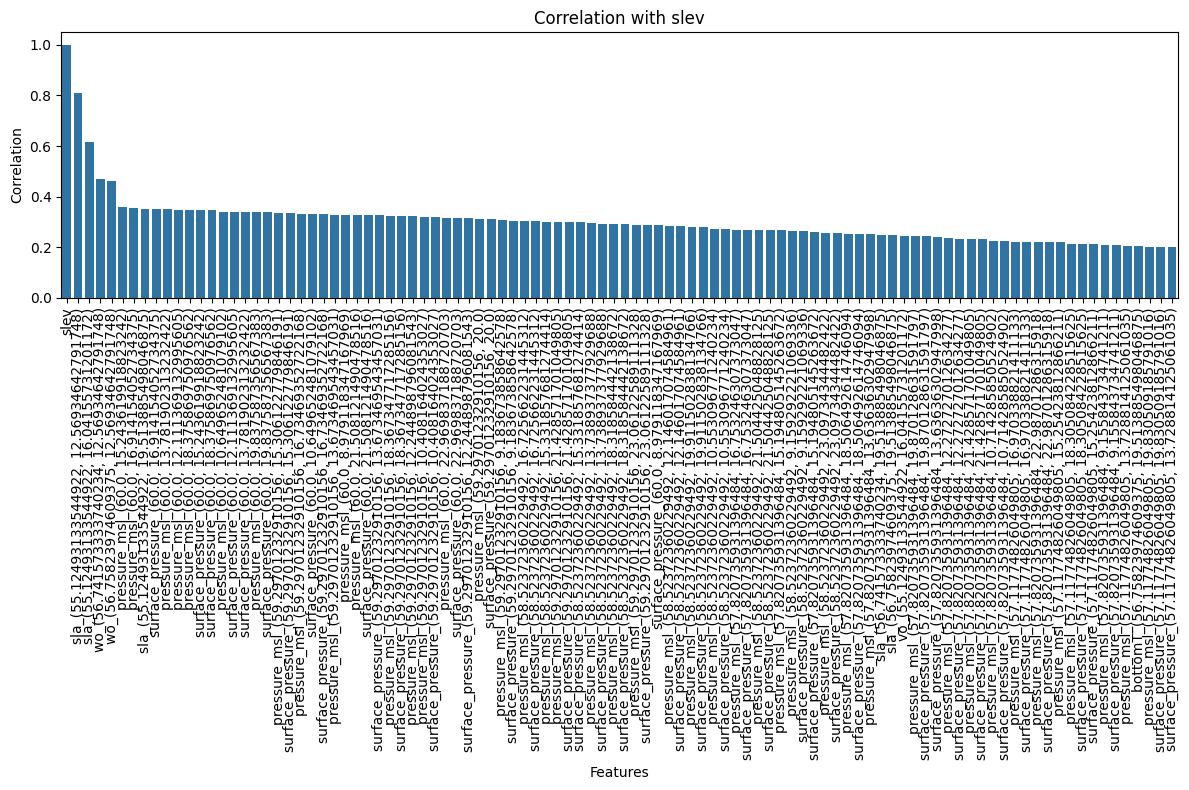

In [ ]:
# Find the highest correlation between the columns and slev
corr_slev = corr["slev"].nlargest(100)


# Display the correlation values in a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=corr_slev.index, y=corr_slev.values)
plt.xticks(rotation=90)
plt.title("Correlation with slev")
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()

In [ ]:
corr_slev.index 

Index(['slev', 'sla_(55.12493133544922, 12.56934642791748)',
       'sla_(55.12493133544922, 16.04155731201172)',
       'wo_(56.741573333740234, 12.56934642791748)',
       'wo_(56.75823974609375, 12.56934642791748)',
       'pressure_msl_(60.0, 15.243619918823242)',
       'pressure_msl_(60.0, 16.914154052734375)',
       'sla_(55.12493133544922, 19.513885498046875)',
       'surface_pressure_(60.0, 16.914154052734375)',
       'pressure_msl_(60.0, 13.781902313232422)',
       'pressure_msl_(60.0, 12.111369132995605)',
       'pressure_msl_(60.0, 18.375869750976562)',
       'surface_pressure_(60.0, 15.243619918823242)',
       'surface_pressure_(60.0, 18.375869750976562)',
       'pressure_msl_(60.0, 10.649652481079102)',
       'surface_pressure_(60.0, 12.111369132995605)',
       'surface_pressure_(60.0, 13.781902313232422)',
       'pressure_msl_(60.0, 19.837587356567383)',
       'surface_pressure_(60.0, 19.837587356567383)',
       'pressure_msl_(59.29701232910156, 15.306122779

Wind column: sla_(55.12493133544922, 12.56934642791748)


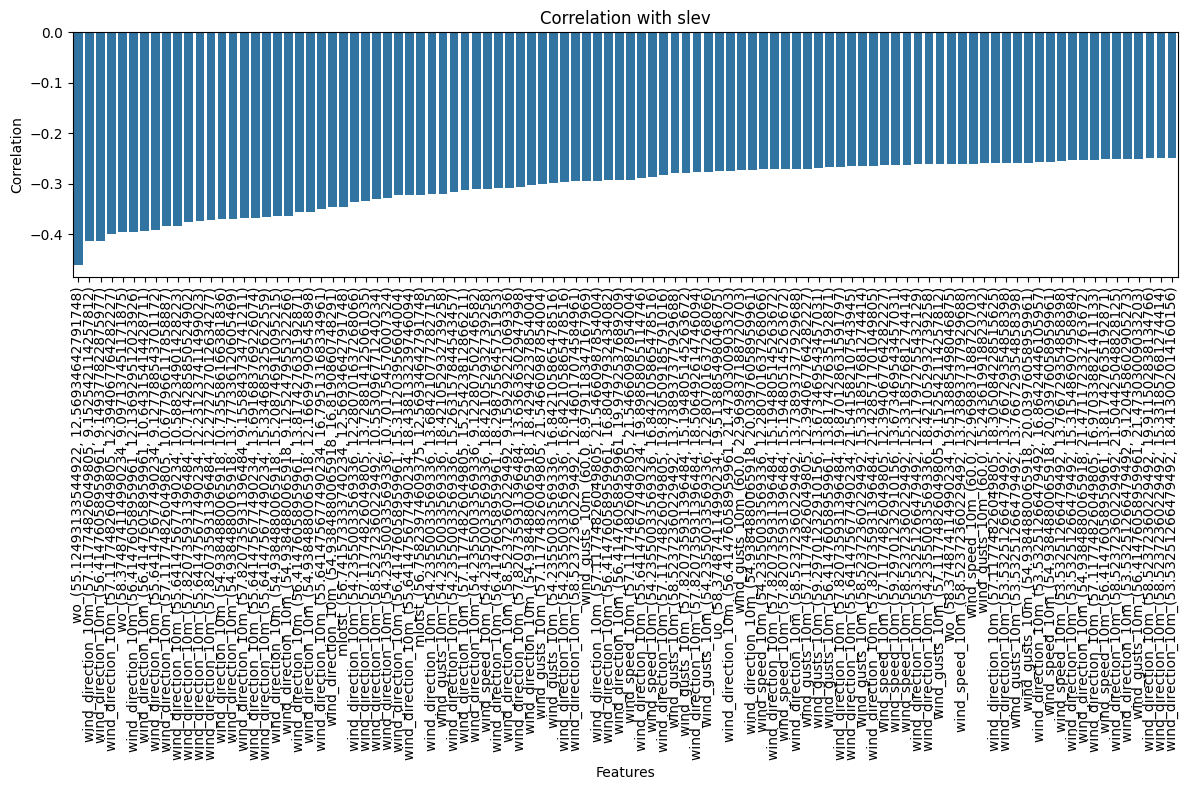

In [ ]:
# Find the highest correlation between the columns and slev
corr_slev = corr["slev"].nsmallest(100)


# Display the correlation values in a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=corr_slev.index, y=corr_slev.values)
plt.xticks(rotation=90)
plt.title("Correlation with slev")
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()

In [ ]:
def get_index_name(corr_slev: pd.Series, name: str) -> str:
    """
    Get the first index name that contains the specified substring.
    """
    for col in corr_slev.index:
        if name in col:
            return col
    return None

# Get the index name of the column that contains 'wind'
sla_col = get_index_name(corr_slev, "sla")
wo_col = get_index_name(corr_slev, "wo")
pressure_msl_col = get_index_name(corr_slev, "pressure_msl")
surface_pressure_col = get_index_name(corr_slev, "surface_pressure")
print(f"Wind column: {sla_col}")


Wind column: sla_(55.12493133544922, 12.56934642791748)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def scale_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Scale the DataFrame using MinMaxScaler, excluding the 'time' column.
    """
    scaler = MinMaxScaler()
    
    # Save time column and drop it from the data to be scaled
    time = df["time"]
    data_to_scale = df.drop(columns=["time"])

    # Fit and transform the data (excluding 'time')
    scaled_values = scaler.fit_transform(data_to_scale)

    # Create scaled DataFrame
    df_scaled = pd.DataFrame(scaled_values, columns=data_to_scale.columns)
    df_scaled["time"] = time

    return df_scaled

# Beispiel-Nutzung
df_scaled = scale_df(df_merged)


In [ ]:
def get_position_of_column(df: pd.DataFrame, col_name: str) -> tuple:
    """
    Get the position (latitude, longitude) of a specific column in the DataFrame.
    """
    # Split the column name to extract latitude and longitude
    parts = col_name.split("_")[-1]
    parts = eval(parts)
    lat = float(parts[-2])
    lon = float(parts[-1])
    return lat, lon

In [ ]:
pressure_msl_col

'pressure_msl_(60.0, 15.243619918823242)'

Position of wo_(56.741573333740234, 12.56934642791748): 56.741573333740234, 12.56934642791748


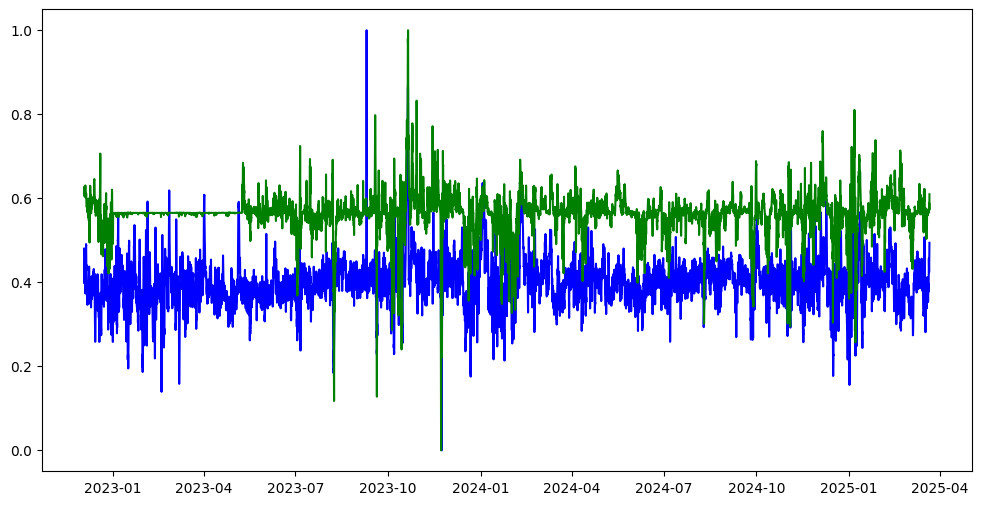

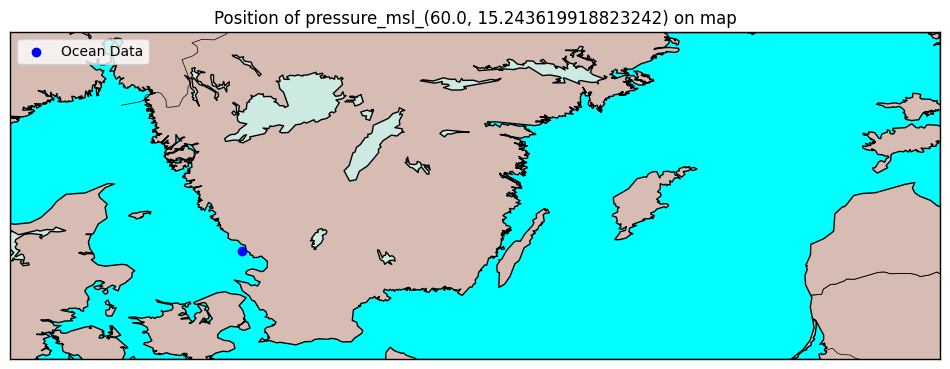

In [ ]:
# Plot slev

# normalize the like MinMaxScaler


fig, ax = plt.subplots(figsize=(12, 6))

# Plot the water level
ax.plot(df_scaled['time'], df_scaled['slev'], label='Wasserstand', color='blue')

# plot the sla_col 
#ax.plot(df_scaled['time'], df_scaled[sla_col], label=sla_col, color='red')

ax.plot(df_scaled['time'], df_scaled[wo_col], label=wo_col, color='green')

#ax.plot(df_scaled['time'], df_scaled[pressure_msl_col], label=pressure_msl_col, color='orange')


# plot the position of the column on map
lat, lon = get_position_of_column(df_scaled, wo_col)
print(f"Position of {wo_col}: {lat}, {lon}")
# Create a Basemap
fig_map, ax_map = plt.subplots(figsize=(12, 10))
m = Basemap(
    projection="cyl",
    resolution="i",
    llcrnrlon=lon_grid.min(),
    urcrnrlon=lon_grid.max(),
    llcrnrlat=lat_grid.min(),
    urcrnrlat=lat_grid.max(),
    ax=ax_map,
)
# Draw map features
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color="0.8")
m.drawstates()
m.drawmapboundary(fill_color="aqua")
m.fillcontinents(color="coral", lake_color="aqua", alpha=0.2)
# Scatterplot for ocean data
x, y = m(lon, lat)
m.scatter(x, y, color="blue", label="Ocean Data", zorder=5)
# Add a title and legend
plt.title(f"Position of {pressure_msl_col} on map")
plt.legend(loc="upper left")
plt.show()

